## Helper functions

In [3]:
%cd "~/projects/spartDM"
%load_ext autoreload
%autoreload 2

import os

print(f"Current working dir: {os.getcwd()}")

import numpy as np
from src.data.datamodules import StarmenDataset
from monai.data import DataLoader
from src.sadm.utils import plot_multi_imgs
from src.utils.metrics import percnorm, mse, mae
import json
import torch
import torch.nn.functional as F
from monai.transforms import ScaleIntensity
from einops import rearrange
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from src.utils.visualization import filter_gt_ano_region
import torchvision
from src.utils.visualization import plot_comparison_starmen, plot_kde_pixel, draw_featmap, plot_fam_error_histogram
from src.ldae.utils import heat_map, feature_distance, patchify
from skimage.filters import threshold_yen, threshold_otsu


from functools import partial

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Constant variables and helper functions

DATA_DIR = "data/starmen/output_random_noacc"
WORK_DIR = "workdir/diffae_starmen"


# Helper function to quick plot a tensor using torchvision grid
def quick_plot_tensor(x, title, normalize=True):
    """
    x: torch.tensor of size(B, C, H, W)
    """
    if isinstance(x, np.ndarray):
        x = torch.tensor(x, dtype=torch.float32)
    grid = torchvision.utils.make_grid(x, nrow=10, normalize=normalize, padding=1)  # noqa: F821
    plt.figure(figsize=(16, 4))  
    plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.title(title)
    plt.axis("off")

def convert_to_torch(x, add_color_channel=True, device=torch.device("cpu")):
    """
    convert a numpy array to torch.Tensor with option to add C channel
    """
    if add_color_channel:
        x = rearrange(x, "b h w -> b 1 h w")
    x = torch.tensor(x, dtype=torch.float32).to(device)
    return x

to_torch = partial(torch.tensor, dtype=torch.float32, device=device)


def filter_threshold(x):
    """
    Filter out anomaly by a simple threshold
    Args: 
        x (torch.Tensor): input image [B, C, H, W]

    Returns: 
        x_thresholded (torch.Tensor): thresholded image. 
    """

    # # arbitrar value
    # threshold = 0.01

    # # max value per image
    # threshold = np.max(test.detach().cpu().numpy(), axis=(2, 3))
    # threshold = rearrange(threshold, "b 1 -> b 1 1 1")

    # 99pct quantile
    threshold = np.quantile(
        x.detach().cpu().numpy(),
        q=0.99,
        axis=(2, 3)
    )
    threshold = rearrange(threshold, "b 1 -> b 1 1 1")
    threshold = to_torch(threshold)
    return torch.where(x >= threshold, x, 0)


/home/kdang/projects/spartDM
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current working dir: /home/kdang/projects/spartDM


/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
"""
Functions to create data table from eval_dict
and export to Latex table
"""

import pandas as pd

# Format function with scale
def fmt_scaled(mean, std=None, scale=1_000):  # scale to e-3

    if np.isnan(mean) or np.isnan(std):
        return np.nan
    
    mean_scaled = mean * scale
    if std is not None:
        std_scaled = std * scale
        return f"{mean_scaled:.2f} ± {std_scaled:.2f}"
    else:
        return f"{mean_scaled:.2f}"

# Format function without scaling
def fmt(mean, std=None):
    if np.isnan(mean):
        return np.nan
    else:
        return f"{mean:.2f} ± {std:.2f}" if std is not None else f"{mean:.2f}"


def create_df_from_dict(data_dict, data_type="darker\_line"):
    data = {
    ("l1", "l1All"):     fmt_scaled(data_dict["l1errAllMean"], data_dict["l1errAllStd"]),
    ("l1", "l1Anomaly"): fmt_scaled(data_dict["l1errAnomalyMean"], data_dict["l1errAnomalyStd"]),
    ("l1", "l1Healthy"): fmt_scaled(data_dict["l1errHealthyMean"], data_dict["l1errHealthyStd"]),
    ("l1", "l1ratio"):   fmt(data_dict["l1ratio"]),
    ("l2", "l2All"):     fmt_scaled(data_dict["l2errAllMean"], data_dict["l2errAllStd"]),
    ("l2", "l2Anomaly"): fmt_scaled(data_dict["l2errAnomalyMean"], data_dict["l2errAnomalyStd"]),
    ("l2", "l2Healthy"): fmt_scaled(data_dict["l2errHealthyMean"], data_dict["l2errHealthyStd"]),
    ("fd", "fdAll"):     fmt_scaled(data_dict["fdAllMean"], data_dict["fdAllStd"]),
    ("fd", "fdAnomaly"): fmt_scaled(data_dict["fdAnomalyMean"], data_dict["fdAnomalyStd"]),
    ("fd", "fdHealthy"): fmt_scaled(data_dict["fdHealthyMean"], data_dict["fdHealthyStd"]),

    ("sim", "SSIM"):     fmt_scaled(data_dict["SSIMMetricsMean"], data_dict["SSIMMetricsStd"], scale=1e2),
    ("sim", "MSSIM"):    fmt_scaled(data_dict["MSSIMMetricsMean"], data_dict["MSSIMMetricsStd"], scale=1e2),
    ("sim", "PSNR"):     fmt(data_dict["PSNRMetricsMean"], data_dict["PSNRMetricsStd"]),

    }

    df = pd.DataFrame.from_dict(data, orient="index", columns=["darker\_line"])
    df.index = pd.MultiIndex.from_tuples(df.index, names=["Metric", "Type"])

    df.columns = pd.MultiIndex.from_tuples([
    (data_type, data_dict["type"])
    ])

    return df


## Load trained model


In [4]:
# CondDDPM model

from src.ldae import CondDDPM
from lightning.pytorch.utilities.model_summary import ModelSummary


## Load model
ckpt_path = os.path.join(WORK_DIR, "representation-learning", "checkpoints", "best.ckpt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

diffae_litmodel = CondDDPM.load_from_checkpoint(ckpt_path, map_location=device)
ema_encoder = diffae_litmodel.ema_encoder
ema_encoder.eval()
ema_decoder = diffae_litmodel.ema_decoder
ema_decoder.eval()
gaussian_diffusion = diffae_litmodel.gaussian_diffusion

# Model summary

summary = ModelSummary(diffae_litmodel, max_depth=1)
print(summary)

Backbone model loaded successfully.
Frozen first 0 layers out of 161 in the backbone

  | Name        | Type            | Params | Mode 
--------------------------------------------------------
0 | decoder     | CondUNet        | 2.5 M  | train
1 | encoder     | SemanticEncoder | 24.6 M | train
2 | ema_encoder | SemanticEncoder | 24.6 M | eval 
3 | ema_decoder | CondUNet        | 2.5 M  | eval 
--------------------------------------------------------
27.1 M    Trainable params
27.1 M    Non-trainable params
54.1 M    Total params
216.547   Total estimated model params size (MB)
492       Modules in train mode
492       Modules in eval mode


### Use fine-tuned FE model

In [5]:
# Fine-tuned feature extractor model

from src.ldae import CondDDPM, FeatureExtractorLitmodel
from lightning.pytorch.utilities.model_summary import ModelSummary


## Load model
ckpt_path = os.path.join(WORK_DIR, "fe-train", "checkpoints", "best.ckpt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

diffae_litmodel = FeatureExtractorLitmodel.load_from_checkpoint(ckpt_path, map_location=device)

ema_encoder = diffae_litmodel.encoder
ema_encoder.eval()
ema_decoder = diffae_litmodel.unet
ema_decoder.eval()
fe = diffae_litmodel.fe
fe = fe.float()
fe.eval()

# Model summary

summary = ModelSummary(diffae_litmodel, max_depth=1)
print(summary)

Backbone model loaded successfully.
Frozen first 0 layers out of 161 in the backbone

Freeze ema_encoder from DDPM models.
Delete litmodel. Only keep UNet and Encoder
  | Name    | Type             | Params | Mode
----------------------------------------------------
0 | encoder | SemanticEncoder  | 24.6 M | eval
1 | unet    | CondUNet         | 2.5 M  | eval
2 | fe      | FeatureExtractor | 17.1 M | eval
----------------------------------------------------
8.5 M     Trainable params
27.1 M    Non-trainable params
35.6 M    Total params
142.422   Total estimated model params size (MB)
0         Modules in train mode
615       Modules in eval mode


## Load dataset and reconstructed results

In [174]:
# Load anomaly test dataset

import json


def load_test_dataset(split="growing_circle20"):

    import json 

    infer_dir = os.path.join(WORK_DIR, "infer", f"{split}_ddim100_noise250")

    # Test dataset
    test_ds = StarmenDataset(
    data_dir=DATA_DIR,
    split=split,
    nb_subject=None,
    )
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=1)
    print(f"Len of test dataset: {len(test_loader)}")


    # Read the reconstruction error files to get the index and corresponding reonconstruction image
    try: 
        eval_result_file = os.path.join(infer_dir, "results", "eval_dict.json")
        with open(eval_result_file, "r") as f:
            eval_dict = json.load(f)
        test_ids = eval_dict["IDs"]
        print(f"Load from eval dict: {eval_result_file}")
    # test_ids = np.load(recons_idx_path)
    # test_ids = test_ids.squeeze().tolist()
    except FileNotFoundError:
        test_ids = test_ds.ids

    # Load the original (anomalious) image from test dataset by index
    x_orgs = [test_ds.get_images_by_id(id)["img"].squeeze() for id in test_ids]
    x_orgs = np.stack(x_orgs).astype("float32")

    # # Load the groundtruth anomaly mask 
    # x_ano_gts = []
    # for id in test_ds.ids:
    #     x_ano_gt = test_ds.get_images_by_id(id)["anomaly_gt_seg"]

    #     if x_ano_gt is None:
    #         break
    #     else:
    #         x_ano_gts.append(x_ano_gt.squeeze())

    # if len(x_ano_gts) > 0: 
    #     x_ano_gts = np.stack(x_ano_gts).astype("float32")
    #     x_ano_gts.shape

    # Load the original healthy images
    # healthy path example= data/starmen/output_random_noacc/images/SimulatedData__Reconstruction__starman__subject_s0__tp_0.npy
    x_hts = []
    for id in test_ids:
        for t in range(0, 10):
            ht_path = os.path.join(DATA_DIR, "images", f"SimulatedData__Reconstruction__starman__subject_s{id}__tp_{t}.npy")
            ht = np.load(ht_path)
            x_hts.append(ht)
    x_hts = np.stack(x_hts)
    x_hts = rearrange(x_hts, "(b t) h w -> b t h w", t=10)
    x_hts.shape

    # add C dimension
    x_orgs = rearrange(x_orgs, "b t h w -> b t 1 h w")
    x_hts = rearrange(x_hts, "b t h w -> b t 1 h w")
    # if len(x_ano_gts) > 0:
    #     x_ano_gts = rearrange(x_ano_gts, "b t h w -> b t 1 h w")

    # Load reconstruction - xT_inferred
    x_recons = np.load(os.path.join(infer_dir, "results", "recons.npy"))
    x_recons.shape

    # Load reconstruction - from random noise
    x_recons_semantic = np.load(os.path.join(infer_dir, "results", "recons_semantic.npy"))
    x_recons_semantic.shape

    # convert to torch
    x_orgs = to_torch(x_orgs) if not isinstance(x_orgs, torch.Tensor) else x_orgs
    x_hts = to_torch(x_hts) if not isinstance(x_hts, torch.Tensor) else x_hts
    x_recons = to_torch(x_recons) if not isinstance(x_recons, torch.Tensor) else x_recons
    x_recons_semantic = to_torch(x_recons_semantic) if not isinstance(x_recons_semantic, torch.Tensor) else x_recons_semantic

    # Calculate ground truth annotation
    diff = torch.abs(x_orgs - x_hts)
    diff = (diff > threshold_yen(diff.numpy())).float()
    # diff[diff < 1e-4] = 0
    # diff = (diff > 0.).bool

    return {
        "eval_result_file": eval_result_file,
        "x_orgs": x_orgs,
        "x_hts": x_hts,
        "x_recons": x_recons,
        "x_recons_semantic": x_recons_semantic,
        "x_ano_gts": diff
    }

# Feature extractor from trained semantic encoder

We will investigate the features extracted from our semantic encoder. 

Len of test dataset: 150
Load from eval dict: workdir/diffae_starmen/infer/test_ddim100_noise250/results/eval_dict.json
torch.Size([150, 10, 1, 64, 64])


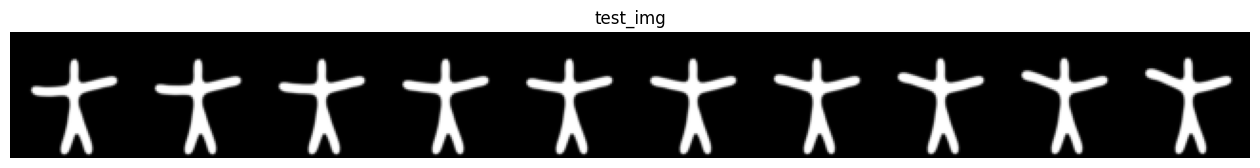

In [26]:
out = load_test_dataset(split="test")
x_orgs = out["x_orgs"]
print(x_orgs.shape)

# Choose 1 patient
pidx = 0
x0 = x_orgs[pidx]

quick_plot_tensor(x0, "test_img")

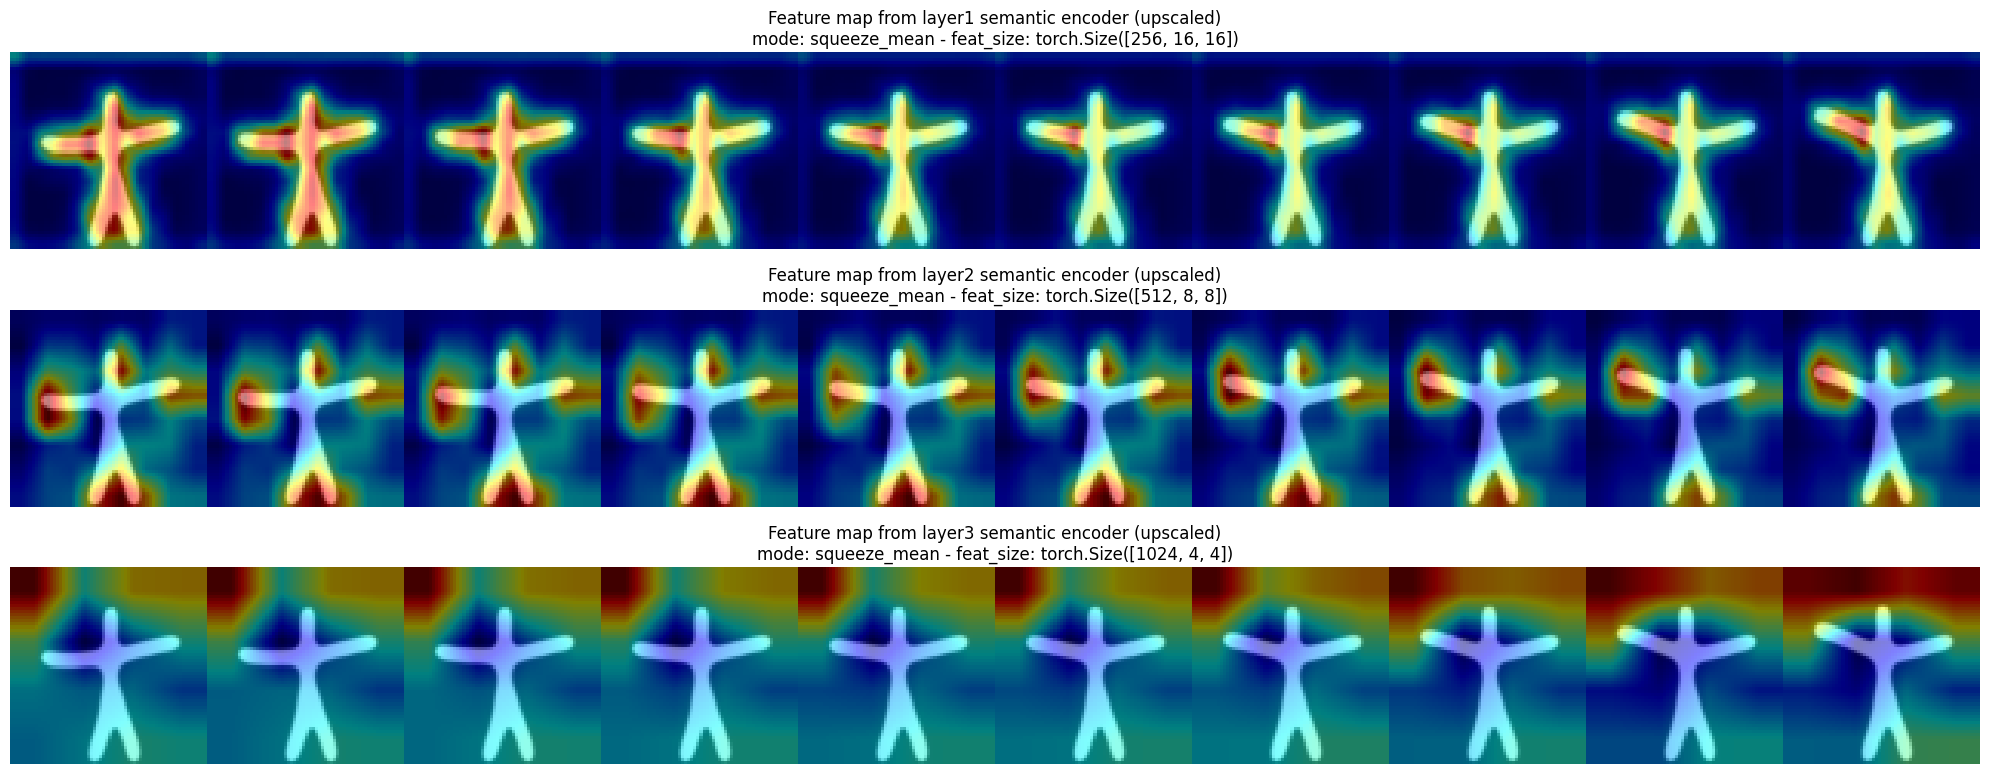

In [27]:
from src.utils.visualization import draw_featmap

# Run 1 pass through semantic encoder

out_frozen_fe, out_fe = fe(x0, fe_layers=["layer1", "layer2", "layer3"])
out_fe[0].shape

# Plot all feature maps from layer1 to layer3
fig, axes = plt.subplots(len(out_fe), 1, figsize=(20, 8), sharey=True)  

for i in range(3):
    ax = axes[i]
    layer = out_fe[i]

    imgs = []

    for feat, overlay in zip(layer, x0): 

        # use interpolation to upscale feature map
        # feat_up = F.interpolate(feat.unsqueeze(1), size=64, mode='bilinear', align_corners=True)
        img = draw_featmap(featmap=feat, overlaid_image=overlay)
        imgs.append(img)

    imgs = np.stack(imgs)
    imgs = rearrange(imgs, "b h w c -> h (b w) c")

    ax.imshow(imgs)
    ax.set_title(f"Feature map from layer{i+1} semantic encoder (upscaled)\nmode: squeeze_mean - feat_size: {layer[0].shape}")
    ax.axis("off")

plt.tight_layout()
plt.show()

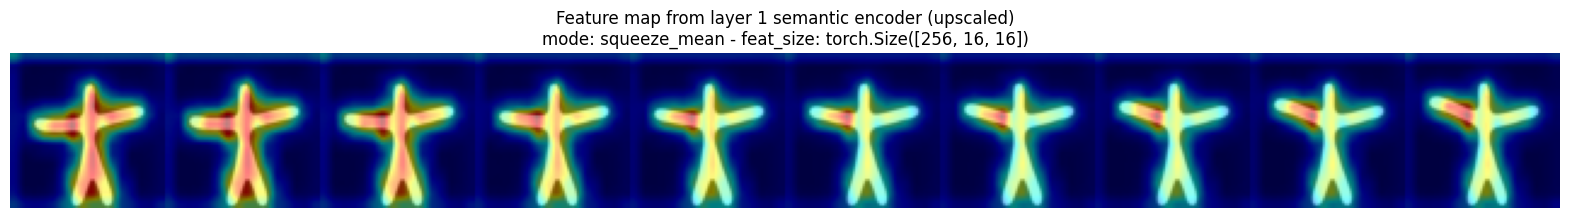

In [ ]:
# Example of 1 specific layer
layer_id = 0
layer = out_fe[layer_id]

imgs = []
for feat, overlay in zip(layer, x0): 
    img = draw_featmap(featmap=feat, overlaid_image=overlay)
    imgs.append(img)

imgs = np.stack(imgs)
imgs = rearrange(imgs, "b h w c -> h (b w) c")

fig = plt.figure(figsize=(20, 6))
plt.imshow(imgs)
plt.axis("off")
plt.title(f"Feature map from layer {layer_id+1} semantic encoder (upscaled)\nmode: squeeze_mean - feat_size: {layer[0].shape}")
plt.show()

## LDA of ysem between healthy and anomaly

In [29]:
x_orgs = out["x_orgs"]
x_hts = out["x_hts"]

pidx = 10
x0_ano = x_orgs[pidx]
x0_ht = x_hts[pidx]

ysem_ano = ema_encoder(x0_ano)
ysem_ht = ema_encoder(x0_ht)

ysem_ano.shape

torch.Size([10, 512])

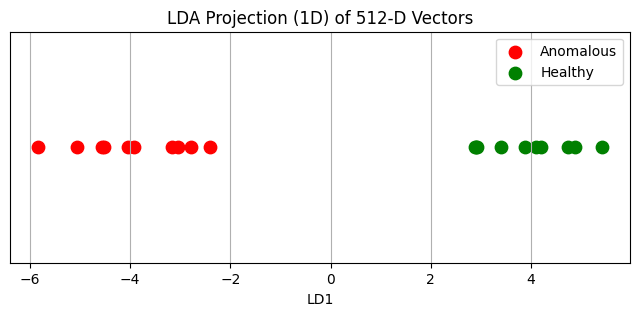

In [104]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


X = torch.cat([ysem_ano, ysem_ht], dim=0).numpy()  # shape (20, 512)

# Step 2: Create labels
# 0 for anomalous, 1 for healthy
y = np.array([0] * 10 + [1] * 10)

# Step 3: Fit LDA
lda = LinearDiscriminantAnalysis(n_components=1)  # 1D because only 2 classes
X_lda = lda.fit_transform(X, y)  # shape (20, 1)

# Step 4: Plot (we can expand to 2D using dummy axis)
plt.figure(figsize=(8, 3))
plt.scatter(X_lda[:10], np.zeros(10), color='red', label='Anomalous', s=80)
plt.scatter(X_lda[10:], np.zeros(10), color='green', label='Healthy', s=80)
plt.xlabel("LD1")
plt.title("LDA Projection (1D) of 512-D Vectors")
plt.legend()
plt.yticks([])
plt.grid(True)
plt.show()

## t-SNE project


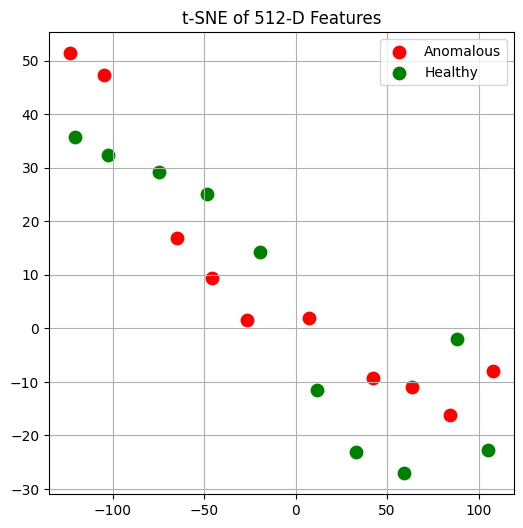

In [111]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Step 1: Prepare data
X = torch.cat([ysem_ano, ysem_ht], dim=0).numpy()  # shape (20, 512)
y = np.array([0] * 10 + [1] * 10)  # 0 = anomalous, 1 = healthy

# Step 2: Run t-SNE (project to 2D)
tsne = TSNE(n_components=2, perplexity=5, learning_rate='auto', init='random', random_state=42)
X_tsne = tsne.fit_transform(X)  # shape (20, 2)

# Step 3: Plot
plt.figure(figsize=(6, 6))
plt.scatter(X_tsne[y == 0, 0], X_tsne[y == 0, 1], color='red', label='Anomalous', s=80)
plt.scatter(X_tsne[y == 1, 0], X_tsne[y == 1, 1], color='green', label='Healthy', s=80)
plt.title("t-SNE of 512-D Features")
plt.legend()
plt.grid(True)
plt.show()


### PCA 

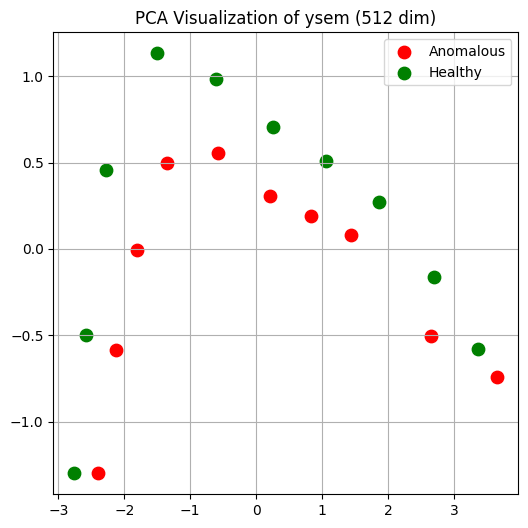

In [112]:
from sklearn.decomposition import PCA

# Use the same X and y as before
# X: shape (20, 512), y: [0]*10 + [1]*10

# Step 1: Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Step 2: Plot PCA result
plt.figure(figsize=(6, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], color='red', label='Anomalous', s=80)
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], color='green', label='Healthy', s=80)
plt.title("PCA Visualization of ysem (512 dim)")
plt.legend()
plt.grid(True)
plt.show()


# Ano heat map

Len of test dataset: 20
Load from eval dict: workdir/diffae_starmen/infer/darker_circle20_ddim100_noise250/results/eval_dict.json


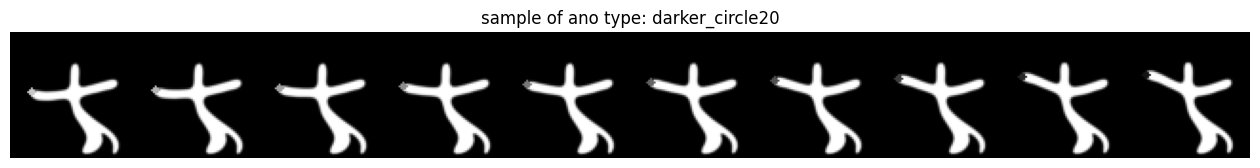

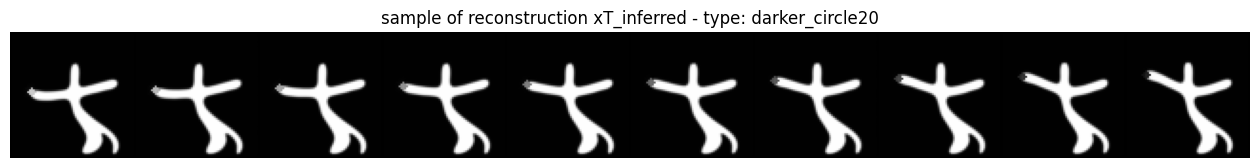

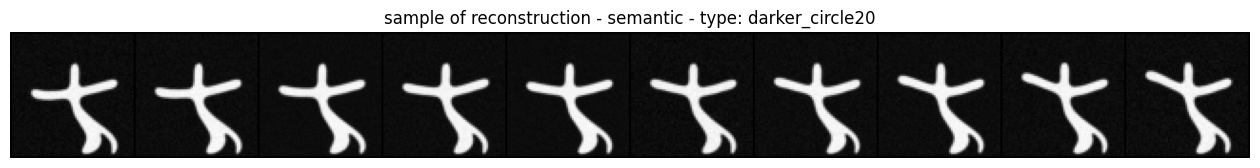

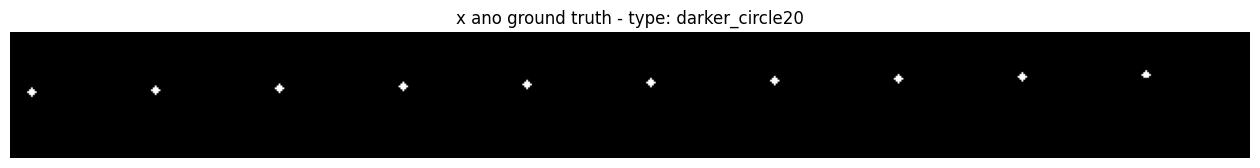

In [180]:
split = "darker_circle20"
out = load_test_dataset(split=split)

x_orgs = out["x_orgs"]
x_recons = out["x_recons"]
x_recons_semantic = out["x_recons_semantic"]
x_ano_gts = out["x_ano_gts"]

# plot a sample image
pidx = 9

quick_plot_tensor(x_orgs[pidx], f"sample of ano type: {split}")
quick_plot_tensor(x_recons[pidx], f"sample of reconstruction xT_inferred - type: {split}")
quick_plot_tensor(x_recons_semantic[pidx], f"sample of reconstruction - semantic - type: {split}")
quick_plot_tensor(x_ano_gts[pidx], f"x ano ground truth - type: {split}")

## Histogram all pixel errors

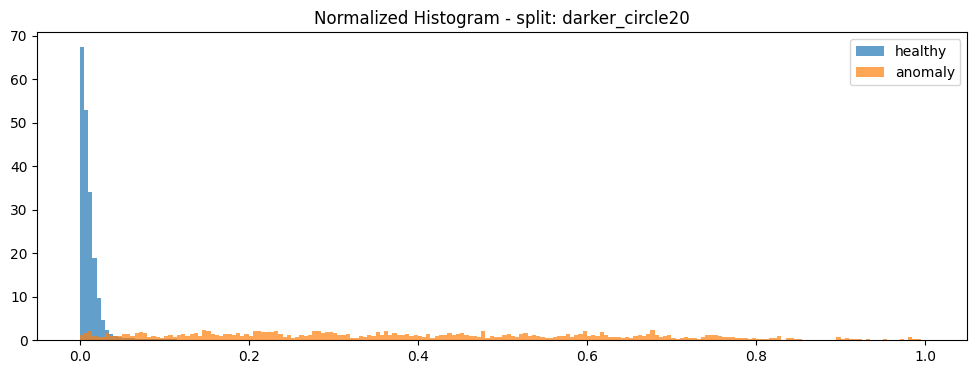

In [181]:
x_ano_gts = out["x_ano_gts"]

i_d_all = torch.abs(x_orgs - x_recons_semantic)
i_d_ano = i_d_all[x_ano_gts > 0.]
i_d_ht = i_d_all[x_ano_gts == 0.]

i_d_ano_hist, bin_edges = np.histogram(i_d_ano, bins=200, range=(0, 1.), density=True)
i_d_ht_hist, bin_edges = np.histogram(i_d_ht, bins=200, range=(0, 1.), density=True)

plt.figure(figsize=(12,4))
plt.bar(bin_edges[:-1], i_d_ht_hist, width=np.diff(bin_edges), align="edge", alpha=0.7, label="healthy")
plt.bar(bin_edges[:-1], i_d_ano_hist, width=np.diff(bin_edges), align="edge", alpha=0.7, label="anomaly")
# plt.xlabel("Pixel Intensity")
# plt.ylabel("Density")
plt.title(f"Normalized Histogram - split: {split}")
plt.legend()
plt.show()

## Eval metrics


In [42]:
eval_result_file = out["eval_result_file"]
print(eval_result_file)

with open(eval_result_file, "r") as f:
    eval_dict = json.load(f)

eval_dict["error_infer"]

workdir/diffae_starmen/infer/darker_line20_ddim100_noise250/results/eval_dict.json


{'type': 'infer',
 'l1errAllMean': 0.0004741888551507145,
 'l1errAllStd': 0.0018774326890707016,
 'l1errAnomalyMean': 0.014475585892796516,
 'l1errAnomalyStd': 0.010877437889575958,
 'l1errHealthyMean': 0.00040617756894789636,
 'l1errHealthyStd': 0.001417889492586255,
 'l1ratio': 35.63856506347656,
 'l2errAllMean': 3.7496042750717606e-06,
 'l2errAllStd': 4.992221511201933e-05,
 'l2errAnomalyMean': 0.0003278313670307398,
 'l2errAnomalyStd': 0.00046488738735206425,
 'l2errHealthyMean': 2.175388544856105e-06,
 'l2errHealthyStd': 3.069441663683392e-05,
 'fdAllMean': 1.699507629382424e-05,
 'fdAllStd': 4.748717037728056e-05,
 'fdAnomalyMean': 0.00023470218002330512,
 'fdAnomalyStd': 6.703173858113587e-05,
 'fdHealthyMean': 1.593757224327419e-05,
 'fdHealthyStd': 4.486446050577797e-05,
 'SSIMMetricsMean': 0.9993586540222168,
 'SSIMMetricsStd': 0.00037250027526170015,
 'MSSIMMetricsMean': 0.9999575614929199,
 'MSSIMMetricsStd': 3.241554804844782e-05,
 'PSNRMetricsMean': 54.36493682861328,
 'P

In [72]:
# Read results from eval_dict and construc data frame
# Construc pd.DataFrame for error semantic
dict_semantic = eval_dict["error_semantic"]
df_gcircle_semantic  = create_df_from_dict(dict_semantic, "growing\_circle")

# Construct data for error inferred
dict_infer = eval_dict["error_infer"]
df_gcircle_infer  = create_df_from_dict(dict_infer, "growing\_circle")

# Combine all df
full_df = pd.concat([df_gcircle_semantic, df_gcircle_infer, df_gcircle_semantic, df_gcircle_infer, ], axis=1)
full_df

growing\_circle                                  \
                         semantic          infer         semantic   
Metric Type                                                         
l1     l1All        14.93 ± 42.74    0.47 ± 1.88    14.93 ± 42.74   
       l1Anomaly  400.49 ± 240.64  14.48 ± 10.88  400.49 ± 240.64   
       l1Healthy    13.06 ± 28.79    0.41 ± 1.42    13.06 ± 28.79   
       l1ratio              30.66          35.64            30.66   
l2     l2All         2.05 ± 27.42    0.00 ± 0.05     2.05 ± 27.42   
       l2Anomaly  218.28 ± 216.30    0.33 ± 0.46  218.28 ± 216.30   
       l2Healthy     1.00 ± 17.33    0.00 ± 0.03     1.00 ± 17.33   
fd     fdAll          5.65 ± 9.39    0.02 ± 0.05      5.65 ± 9.39   
       fdAnomaly    42.74 ± 22.02    0.23 ± 0.07    42.74 ± 22.02   
       fdHealthy      5.47 ± 8.92    0.02 ± 0.04      5.47 ± 8.92   
sim    SSIM          84.27 ± 4.92   99.94 ± 0.04     84.27 ± 4.92   
       MSSIM         98.30 ± 0.60  100.00 ± 0.00     98.30 ± 0.60   
       PSNR          27.36 ± 2.02   54.36 ± 0.91     27.36 ± 2.02   

                                 
                          infer  
Metric Type                      
l1     l1All        0.47 ± 1.88  
       l1Anomaly  14.48 ± 10.88  
       l1Healthy    0.41 ± 1.42  
       l1ratio            35.64  
l2     l2All        0.00 ± 0.05  
       l2Anomaly    0.33 ± 0.46  
       l2Healthy    0.00 ± 0.03  
fd     fdAll        0.02 ± 0.05  
       fdAnomaly    0.23 ± 0.07  
       fdHealthy    0.02 ± 0.04  
sim    SSIM        99.94 ± 0.04  
       MSSIM      100.00 ± 0.00  
       PSNR        54.36 ± 0.91

In [44]:
# Set the metrics
from monai.metrics.regression import MultiScaleSSIMMetric, PSNRMetric, SSIMMetric
from monai.losses import PerceptualLoss
import torch.nn.functional as F

spartial_dim = 2
ssim = SSIMMetric(spatial_dims=spartial_dim, data_range=1.0, win_size=4)
mssim = MultiScaleSSIMMetric(spatial_dims=spartial_dim, data_range=1.0, kernel_size=4)
psnr = PSNRMetric(max_val=1.0, reduction="mean")

In [ ]:
def test_metrics(eval_dict, x_orgs, x_recons, recon_type="semantic", save_dict=True, save_path=None):

    # pixel distance - l1error
    l1errAll = F.l1_loss(x_orgs, x_recons, reduction="none")

    # pixel distance - l2error
    l2errAll = F.mse_loss(x_orgs, x_recons, reduction="none")

    # pixel distance for anomaly and healthy region
    ano_mask = x_ano_gts > 0
    if torch.any(ano_mask):
        l1errAnomaly = l1errAll[x_ano_gts > 0]
        l1errHealthy = l1errAll[x_ano_gts == 0]
        l2errAnomaly = l2errAll[x_ano_gts > 0]
        l2errHealthy = l2errAll[x_ano_gts == 0]
    else: 
        l1errAnomaly = torch.tensor(float('nan'))
        l1errHealthy = torch.tensor(float('nan'))
        l2errAnomaly = torch.tensor(float('nan'))
        l2errHealthy = torch.tensor(float('nan'))

    # feature distance
    heatmap_v = 4.
    B = x_orgs.shape[0]

    f_ds = []
    ano_maps = []
    for i in range(B):
        x0_ano = x_orgs[i]
        x0_hat = x_recons[i]

        ano_map, f_d, i_d = heat_map(
        x0_hat, x0_ano, fe, v=heatmap_v, fe_layers=["layer1", "layer2", "layer3"]
        )

        f_ds.append(f_d)
        ano_maps.append(ano_map)

    f_ds = torch.stack(f_ds)
    ano_maps = torch.stack(ano_maps)

    if torch.any(ano_mask):
        fdAnomaly = f_ds[x_ano_gts > 0]
        fdHealthy = f_ds[x_ano_gts == 0]
        ano_maps_anomaly = ano_maps[x_ano_gts > 0]
        ano_maps_healthy = ano_maps[x_ano_gts == 0]
    else: 
        fdAnomaly = torch.tensor(float('nan'))
        fdHealthy = torch.tensor(float('nan'))
        ano_maps_anomaly = torch.tensor(float('nan'))
        ano_maps_healthy = torch.tensor(float('nan'))

    """
    Similarity metrics
    """
    if x_orgs.dim() == 5:  # B, T, C, H, W
        x0 = rearrange(x_orgs, "b t c h w -> (b t) c h w")
        xhat = rearrange(x_recons, "b t c h w -> (b t) c h w")
    else: 
        x0 = x_orgs
        xhat = x_recons

    ssim_metric = ssim(x0, xhat)
    mssim_metric = mssim(x0, xhat)
    psnr_metric = psnr(x0, xhat)

    if x_orgs.dim() == 5:
        ssim_metric = rearrange(ssim_metric, "(b t) 1 -> b t", b=x_orgs.shape[0])
        mssim_metric = rearrange(mssim_metric, "(b t) 1 -> b t", b=x_orgs.shape[0])
        psnr_metric = rearrange(psnr_metric, "(b t) 1 -> b t", b=x_orgs.shape[0])
    else: 
        ssim_metric = rearrange(ssim_metric, "b 1 -> 1 b")
        mssim_metric = rearrange(mssim_metric, "b 1 -> 1 b")
        psnr_metric = rearrange(psnr_metric, "b 1 -> 1 b")

    # Write to eval_dict
    error_dict = eval_dict.get(f"error_{type}", dict())
    error_dict["SSIMMetrics"] = ssim_metric.tolist()
    error_dict["MSSIMMetrics"] = mssim_metric.tolist()
    error_dict["PSNRMetrics"] = psnr_metric.tolist()


    """
    Average results and write to eval_dict
    """
    def safe_nanstd(x: torch.Tensor, ddof: int = 1) -> torch.Tensor:
        mask = ~torch.isnan(x)
        valid = mask.sum()
        
        if valid <= ddof:
            return torch.tensor(float('nan'), device=x.device, dtype=x.dtype)
        return torch.std(x[mask], unbiased=(ddof == 1))

    # l1error
    l1errAllMean = torch.nanmean(l1errAll)
    l1errAllStd = safe_nanstd(l1errAll)
    l1errAnomalyMean = torch.nanmean(l1errAnomaly)
    l1errAnomalyStd = safe_nanstd(l1errAnomaly)
    l1errHealthyMean = torch.nanmean(l1errHealthy)
    l1errHealthyStd = safe_nanstd(l1errHealthy)

    l1ratio = l1errAnomalyMean / l1errHealthyMean
    l1ratio

    # l2error
    l2errAllMean = torch.nanmean(l2errAll)
    l2errAllStd = safe_nanstd(l2errAll)
    l2errAnomalyMean = torch.nanmean(l2errAnomaly)
    l2errAnomalyStd = safe_nanstd(l2errAnomaly)
    l2errHealthyMean = torch.nanmean(l2errHealthy)
    l2errHealthyStd = safe_nanstd(l2errHealthy)

    # feature distance
    fdAllMean = torch.nanmean(f_ds)
    fdAllStd = safe_nanstd(f_ds)
    fdAnomalyMean = torch.nanmean(fdAnomaly)
    fdAnomalyStd = safe_nanstd(fdAnomaly)
    fdHealthyMean = torch.nanmean(fdHealthy)
    fdHealthyStd = safe_nanstd(fdHealthy)

    # write to eval_dict
    error_dict = {}
    error_dict["type"] = recon_type
    error_dict["l1errAllMean"] = l1errAllMean
    error_dict["l1errAllStd"] = l1errAllStd
    error_dict["l1errAnomalyMean"] = l1errAnomalyMean
    error_dict["l1errAnomalyStd"] = l1errAnomalyStd
    error_dict["l1errHealthyMean"] = l1errHealthyMean
    error_dict["l1errHealthyStd"] = l1errHealthyStd
    error_dict["l1ratio"] = l1ratio
    error_dict["l2errAllMean"] = l2errAllMean
    error_dict["l2errAllStd"] = l2errAllStd
    error_dict["l2errAnomalyMean"] = l2errAnomalyMean
    error_dict["l2errAnomalyStd"] = l2errAnomalyStd
    error_dict["l2errHealthyMean"] = l2errHealthyMean
    error_dict["l2errHealthyStd"] = l2errHealthyStd

    error_dict["fdAllMean"] = fdAllMean
    error_dict["fdAllStd"] = fdAllStd
    error_dict["fdAnomalyMean"] = fdAnomalyMean
    error_dict["fdAnomalyStd"] = fdAnomalyStd
    error_dict["fdHealthyMean"] = fdHealthyMean
    error_dict["fdHealthyStd"] = fdHealthyStd

    # Similarity metrics
    error_dict["SSIMMetricsMean"] = np.nanmean(ssim_metric).item()
    error_dict["SSIMMetricsStd"] = np.nanstd(ssim_metric).item()

    error_dict["MSSIMMetricsMean"] = np.nanmean(mssim_metric).item()
    error_dict["MSSIMMetricsStd"] = np.nanstd(mssim_metric).item()

    error_dict["PSNRMetricsMean"] = np.nanmean(psnr_metric).item()
    error_dict["PSNRMetricsStd"] = np.nanstd(psnr_metric).item()


    # sanitty check
    for k, v in error_dict.items():
        if isinstance(v, torch.Tensor) and v.dim() == 0:
            error_dict[k] = v.item() 
        if isinstance(v, np.ndarray) and v.dim() == 0:
            error_dict[k] = v.item() 


    eval_dict[f"error_{recon_type}"] = error_dict

    # save eval_dict
    if save_dict: 
        with open(save_path, "w") as f:
            json.dump(eval_dict, f)
    
    return eval_dict

In [ ]:

# # Calculate eval metrics for xT_infer and xT_semantic
# eval_dict = test_metrics(
#     eval_dict, 
#     x_orgs, 
#     x_recons=x_recons_semantic, 
#     recon_type="semantic",
#     save_path=eval_result_file)

# eval_dict = test_metrics(
#     eval_dict, 
#     x_orgs, 
#     x_recons=x_recons, 
#     recon_type="infer",
#     save_path=eval_result_file)

In [ ]:
# plot_kde_pixel(imgs=[l1errAnomaly, ], labels=["Anomaly"])
import seaborn as sns

plot_dict = eval_dict["error_infer"]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# pixel dsitance
ax = axes[0, 0]
sns.histplot(plot_dict["l1errAll"].flatten(), bins=50, stat="percent", ax=ax)
ax.set_title("l1error [All]")


ax = axes[0, 1]
sns.histplot(plot_dict["l1errAnomaly"], bins=50, label="Anomaly", legend=True, stat="percent", ax=ax)
sns.histplot(plot_dict["l1errHealthy"], bins=50, label="Healthy", legend=True, stat="percent", ax=ax)
ax.set_title("l1error [Anomaly vs Healthy]")
ax.legend()

ax = axes[0, 2]
ax.axis("off")

# feature distance
ax = axes[1, 0]
sns.histplot(plot_dict["4"].flatten(), bins=50, stat="percent", ax=ax)
ax.set_title("feature distance [ALL]")

ax = axes[1, 1]
sns.histplot(plot_dict["fdAnomaly"], bins=50, label="Anomaly", legend=True, stat="percent", ax=ax)
sns.histplot(plot_dict["fdHealthy"], bins=50, label="Healthy", legend=True, stat="percent", ax=ax)
ax.set_title("feature distance [Anomaly vs Healthy]")
# ax.set_yscale("log")
ax.legend()

# anomaly maps
ax = axes[1, 2]
sns.histplot(plot_dict["ano_maps_anomaly"], bins=50, label="Anomaly", legend=True, stat="percent", ax=ax)
sns.histplot(plot_dict["ano_maps_healthy"], bins=50, label="Healthy", legend=True, stat="percent", ax=ax)
ax.set_title(f"anomaly_map - v = {4.}")
ax.legend()


# plt.legend()
plt.suptitle("Error histogram - test_ds: darker_line", y=1.01)
plt.tight_layout()
plt.show()

## Reconstruction from UNet

We run a normal reverse diffusion from trained UNet to get x_hat 

sampling loop time step: 100%|██████████| 200/200 [01:28<00:00,  2.25it/s]


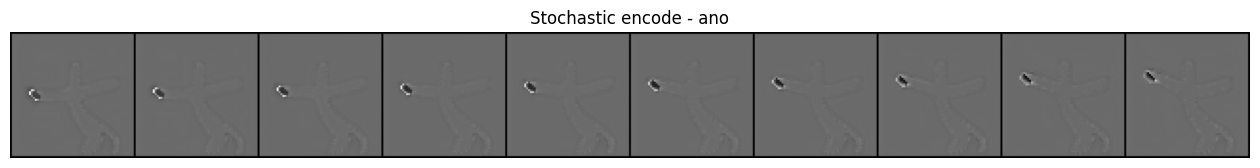

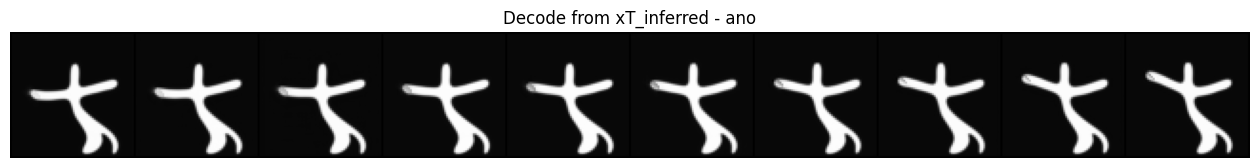

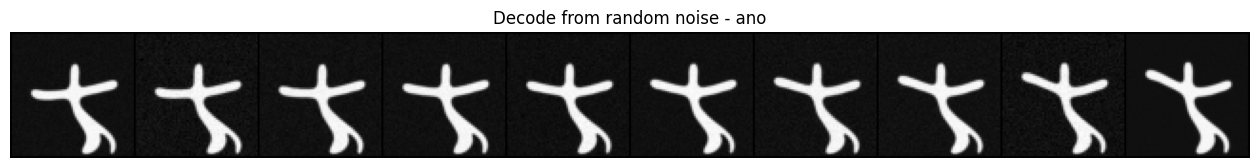

In [556]:

# Stochastic encoder
with torch.no_grad():
    xT_infer = gaussian_diffusion.representation_learning_diffae_encode(
        ddim_style="ddim10",
        encoder=ema_encoder,
        unet=ema_decoder,
        x_0=x0_ano,
        disable_tqdm=False
    )

quick_plot_tensor(xT_infer, title="Stochastic encode - ano")

# Decode from xT_inferred
# We need to sample from enough step to get good result
with torch.no_grad():
    x0_hat = gaussian_diffusion.representation_learning_diffae_sample(
        ddim_style="ddim200",
        encoder=ema_encoder,
        unet=ema_decoder,
        x_0=x0_ano,
        x_T=xT_infer,
        disable_tqdm=False
    )

quick_plot_tensor(x0_hat, title="Decode from xT_inferred - ano")


# Decode from random noise
# We need to sample from enough step to get good result
with torch.no_grad():
    x0_hat_semantic = gaussian_diffusion.representation_learning_diffae_sample(
        ddim_style="ddim200",
        encoder=ema_encoder,
        unet=ema_decoder,
        x_0=x0_ano,
        x_T=torch.randn_like(x0_ano),
        disable_tqdm=False
    )

quick_plot_tensor(x0_hat_semantic, title="Decode from random noise - ano")

In [ ]:
# Save experiment result to load later
# The order is: x0_ano, x0_ht, x0_hat, x0_hat_semantic
exp_result = torch.cat((x0_ano, x0_ht, x0_hat, x0_hat_semantic))
save_path = "notebooks/exp_results/exp_darkerline"
np.save(
    save_path,
    exp_result.detach().cpu().numpy()
)

In [44]:
# Uncomment to Load experiment result
save_path = "notebooks/exp_results/exp_darkerline.npy"
exp_result = np.load(save_path)

# The order is: x0_ano, x0_ht, x0_hat, x0_hat_semantic
exp_result = torch.tensor(exp_result, dtype=torch.float32)
x0_ano, x0_ht, x0_hat, x0_hat_semantic = exp_result.chunk(4)

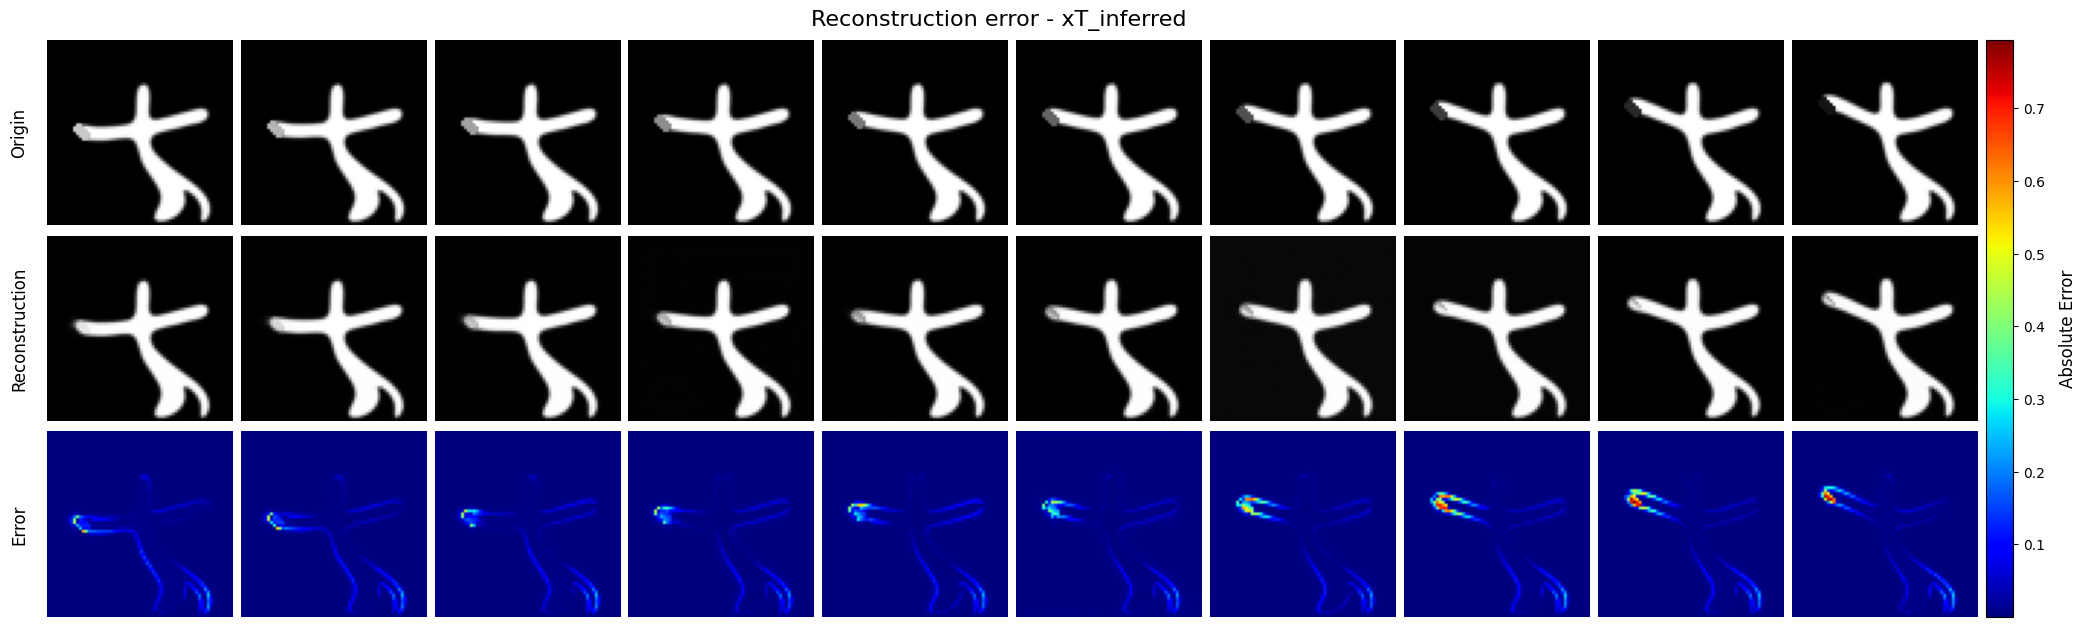

In [45]:
# plot comparison when decode from xt_infer

imgs = [
    x0_ano.detach().cpu().squeeze(), 
    x0_hat.detach().cpu().squeeze(),
    torch.abs(x0_ano - x0_hat).detach().cpu().squeeze(),
]

labels = [
    "Origin",
    "Reconstruction",
    "Error"
]

title = "Reconstruction error - xT_inferred"
opt = {}
opt["title"] = title

fig = plot_comparison_starmen(imgs, 
                              labels, 
                              is_errors=[False, False, True], 
                              opt=opt)

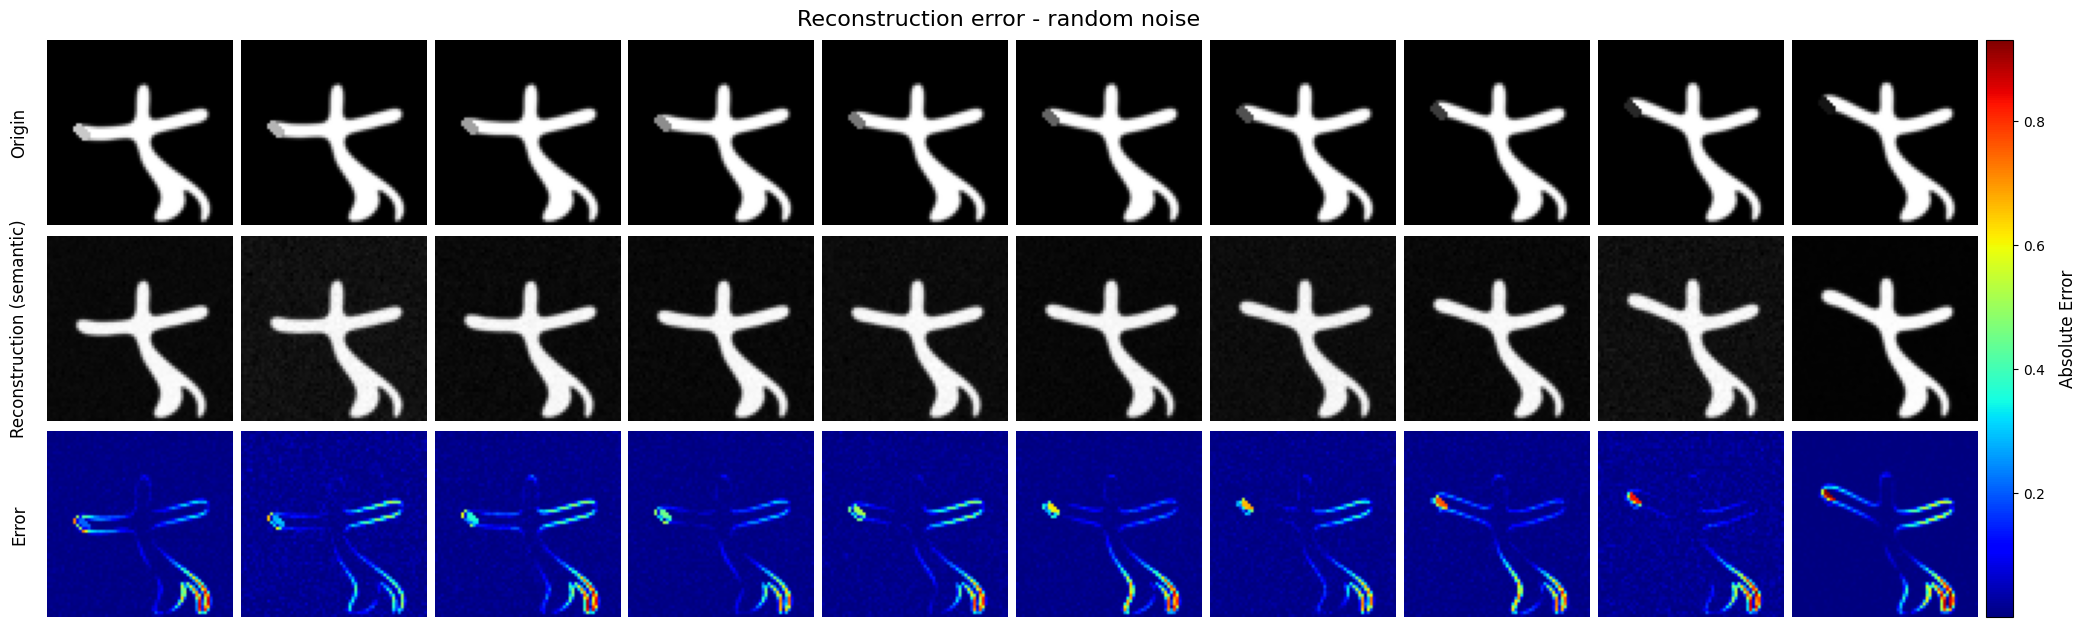

In [47]:
# Plot comparison decode from random noise
imgs = [
    x0_ano.detach().cpu().squeeze(), 
    x0_hat_semantic.detach().cpu().squeeze(),
    torch.abs(x0_ano - x0_hat_semantic).detach().cpu().squeeze(),
]

labels = [
    "Origin",
    "Reconstruction (semantic)",
    "Error"
]

title = "Reconstruction error - random noise"
opt["title"] = title

fig = plot_comparison_starmen(imgs, labels, is_errors=[False, False, True], opt=opt)

## Comparison histogram of xT_infer and xT

sampling loop time step: 100%|██████████| 100/100 [00:05<00:00, 18.45it/s]


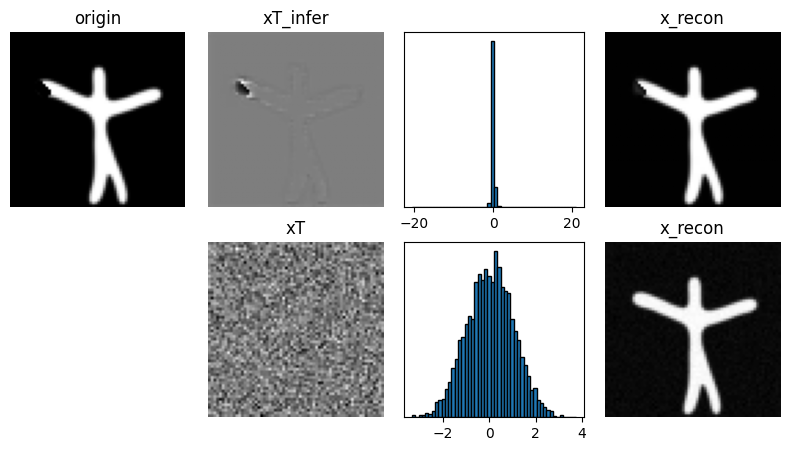

In [182]:
from matplotlib import gridspec

pidx = 9
x0 = x0_ano[[pidx]]

fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(2, 4, figure=fig, wspace=0.1, hspace=0.2)

# original image
ax0 = fig.add_subplot(gs[0, 0])
ax0.imshow(x0.squeeze(), cmap="gray")
ax0.axis("off")
ax0.set_title("origin")

# xT_infer
xT_infer = gaussian_diffusion.representation_learning_diffae_encode(
    ddim_style="ddim100",
    encoder=ema_encoder,
    unet=ema_decoder,
    x_0=x0,
    # noise_level=100,
    z=None,
    disable_tqdm=False,
    return_intermediate=False
)
ax = fig.add_subplot(gs[0, 1])
ax.imshow(xT_infer.squeeze(), cmap="gray")
ax.axis("off")
ax.set_title("xT_infer")


# xT_infer histogram
# Flatten image to 1D array of pixel values
ax = fig.add_subplot(gs[0, 2])
pixels = xT_infer.numpy().squeeze().flatten()
ax.hist(pixels, bins=50, edgecolor='black')
# ax.set_xticks([])
ax.set_yticks([])
# ax.set_aspect(aspect='equal', adjustable='box')  # match square shape of images

# Reconstruction from xT
x_recon_infer = gaussian_diffusion.representation_learning_diffae_sample(
    ddim_style="ddim100",
    encoder=ema_encoder,
    unet=ema_decoder,
    x_0=x0,
    x_T=xT_infer,
    disable_tqdm=False,
)
ax = fig.add_subplot(gs[0, 3])
ax.imshow(x_recon_infer.squeeze(), cmap="gray")
ax.axis("off")
ax.set_title("x_recon")

# normal noisy xFalse
xT = gaussian_diffusion.q_sample(x0, t=999)
ax = fig.add_subplot(gs[1, 1])
ax.imshow(xT.squeeze(), cmap="gray")
ax.axis("off")
ax.set_title("xT")

pixels = xT.numpy().squeeze().flatten()
ax = fig.add_subplot(gs[1, 2])
ax.hist(pixels, bins=50, edgecolor='black')
# ax.set_xticks([])
ax.set_yticks([])

x_recon_semantic = gaussian_diffusion.representation_learning_diffae_sample(
        ddim_style="ddim100",
        encoder=ema_encoder,
        unet=ema_decoder,
        x_0=x0,
        x_T=xT,
        disable_tqdm=False,
    )
ax = fig.add_subplot(gs[1, 3])
ax.imshow(x_recon_semantic.squeeze(), cmap="gray")
ax.axis("off")
ax.set_title("x_recon")

plt.show()

## Feature extractions of x0 and x0_hat


In [49]:
# take the output all all layers
fe_layers = ["layer1", "layer2", "layer3"]

_, x0_fe = fe(x0_ano, fe_layers=fe_layers)

_, x0_hat_fe = fe(x0_hat, fe_layers=fe_layers)

_, x0_hat_semantic_fe = fe(x0_hat_semantic, fe_layers=fe_layers)


x0_hat_fe shape: torch.Size([10, 256, 16, 16])
torch.Size([10, 16, 16])


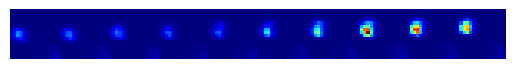

In [53]:
layer_id = 0
print(f"x0_hat_fe shape: {x0_hat_fe[layer_id].shape}")

# Test - cosine similarity between feat map of origin x0_ano and reconstruced x0_hat
patched_x0_hat = patchify(x0_hat_fe[layer_id])
patched_x0 = patchify(x0_fe[layer_id])
patched_x0.shape

a_map = 1 - F.cosine_similarity(patched_x0_hat, patched_x0)
print(a_map.shape)

# plot
img = rearrange(a_map, "b h w -> h (b w)")
plt.imshow(img, cmap="jet")
plt.axis("off")
plt.show()

(64, 640, 3)
(64, 640, 3)
(64, 640, 3)


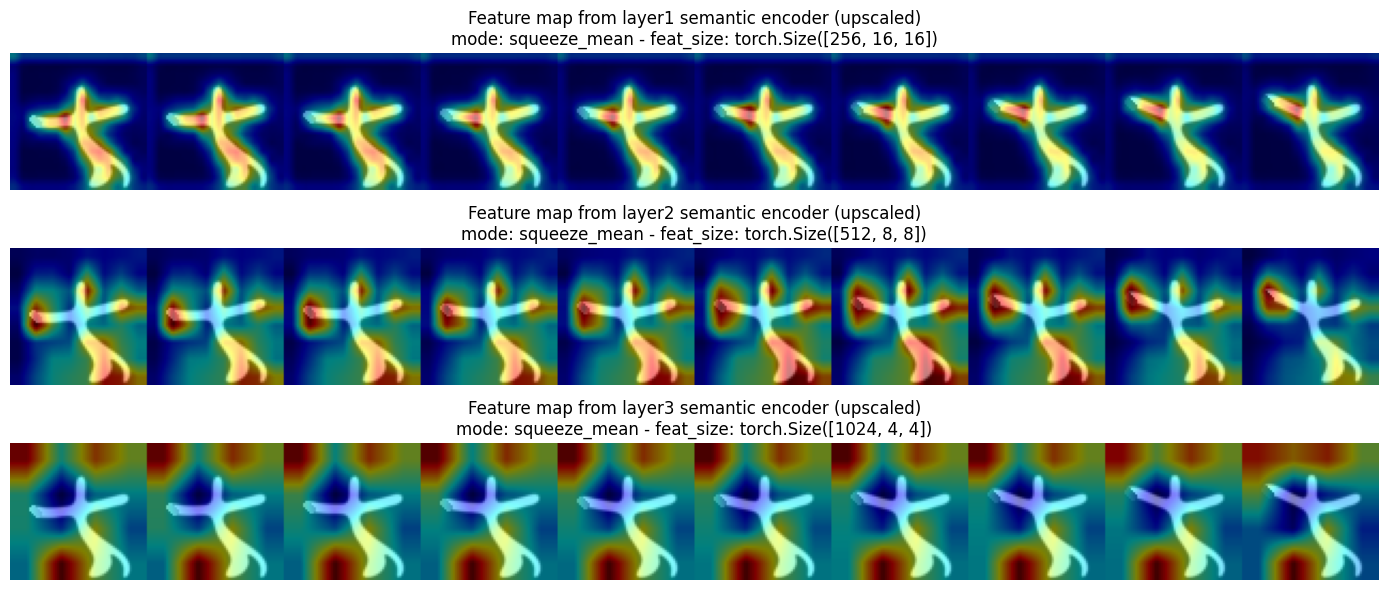

In [54]:
# Plot all feature maps from layer1 to layer3
out_fe = x0_hat_fe

nrow = len(out_fe)
ncol = 1
fig, axes = plt.subplots(nrow, ncol, figsize=(2.*10.*ncol, 2.*nrow), sharey=True)  

for i in range(len(out_fe)):
    ax = axes[i]
    layer = out_fe[i]

    imgs = []

    for feat, overlay in zip(layer, x0_ano): 

        # use interpolation to upscale feature map
        # feat_up = F.interpolate(feat.unsqueeze(1), size=64, mode='bilinear', align_corners=True)
        img = draw_featmap(featmap=feat, overlaid_image=overlay)
        # print(img.shape)
        imgs.append(img)

    imgs = np.stack(imgs)
    imgs = rearrange(imgs, "b h w c -> h (b w) c")
    print(imgs.shape)

    ax.imshow(imgs)
    ax.set_title(f"Feature map from {fe_layers[i]} semantic encoder (upscaled)\nmode: squeeze_mean - feat_size: {layer[0].shape}")
    ax.axis("off")

plt.tight_layout()
plt.show()

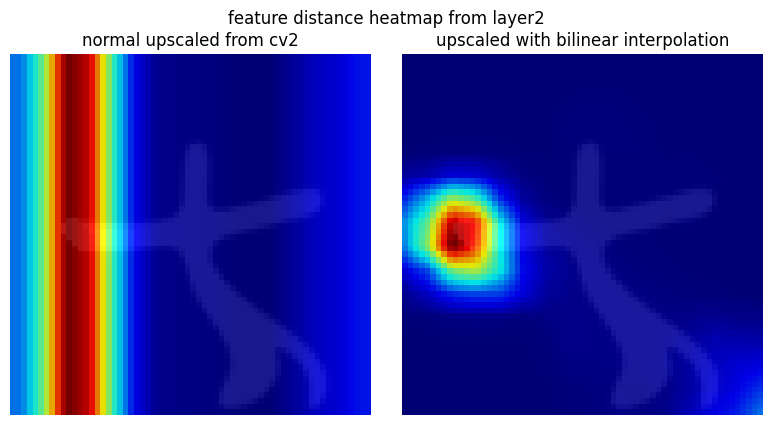

In [56]:
out_size = 64

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# normal upscale from cv2
ax = axes[0]
img = draw_featmap(a_map[0].unsqueeze(1), x0_ano[0], alpha=0.9)
ax.imshow(img)
ax.axis("off")
ax.set_title("normal upscaled from cv2")

# upscale using bilinear interpolation 
a_map_upscale = F.interpolate(a_map.unsqueeze(1), size=out_size, mode='bilinear', align_corners=True)
a_map_upscale.shape

img = draw_featmap(a_map_upscale[0], x0_ano[0], alpha=0.9)
ax = axes[1]
ax.imshow(img)
ax.axis("off")
ax.set_title("upscaled with bilinear interpolation")

plt.tight_layout()
plt.suptitle("feature distance heatmap from layer2", y=1.05)
plt.show()

## Anomaly heatmap - xT_infer

In [73]:
# Load 1 sample image
pidx = 9
x0_ano = out["x_orgs"][pidx]
x0_hat = out["x_recons"][pidx]
i_d = torch.abs(x0_ano - x0_hat)
# x0_hat_semantic = x_recons_semantic[pidx]

### Pixel distance

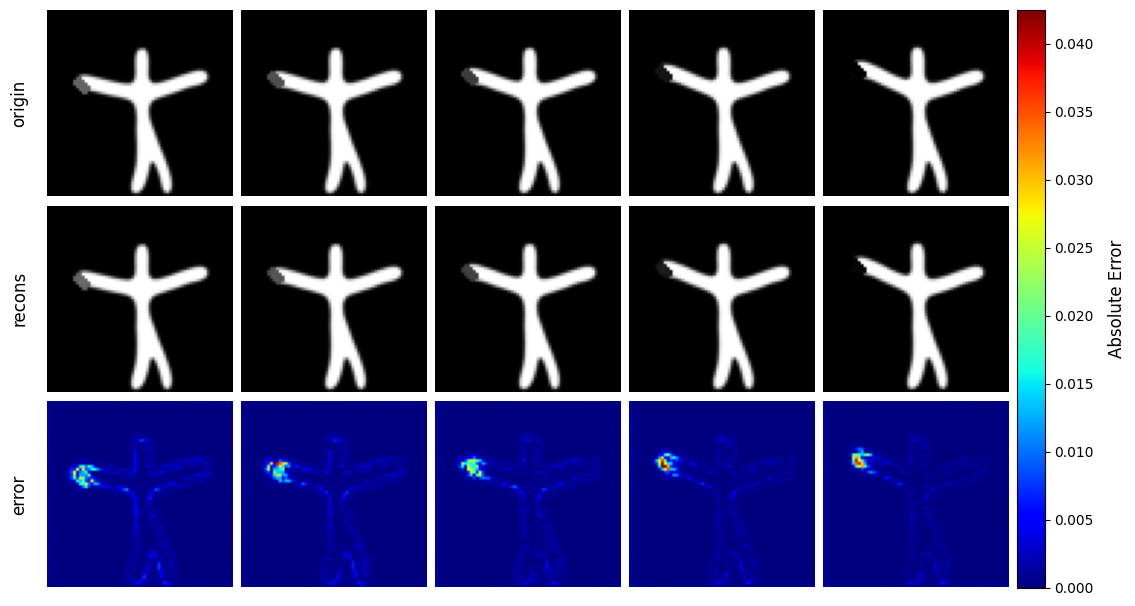

In [75]:
# Plot anomaly score map
imgs = [
    x0_ano.detach().cpu().squeeze()[5:],
    x0_hat.detach().cpu().squeeze()[5:],
    i_d.detach().cpu().squeeze()[5:],
]

labels = ["origin", "recons", "error", "ano_score_map"]

# title = f"Anomaly score map - xT_infer - {split} - v={heatmap_v}"
# opt = {"title": title}

fig = plot_comparison_starmen(
    imgs,
    labels,
    is_errors=[False, False, True, True, True],
    # opt=opt,
    same_cbar=True,
    display_cbar=True,
)

fig.savefig("notebooks/temp/pixel-error.svg")

### FAM score

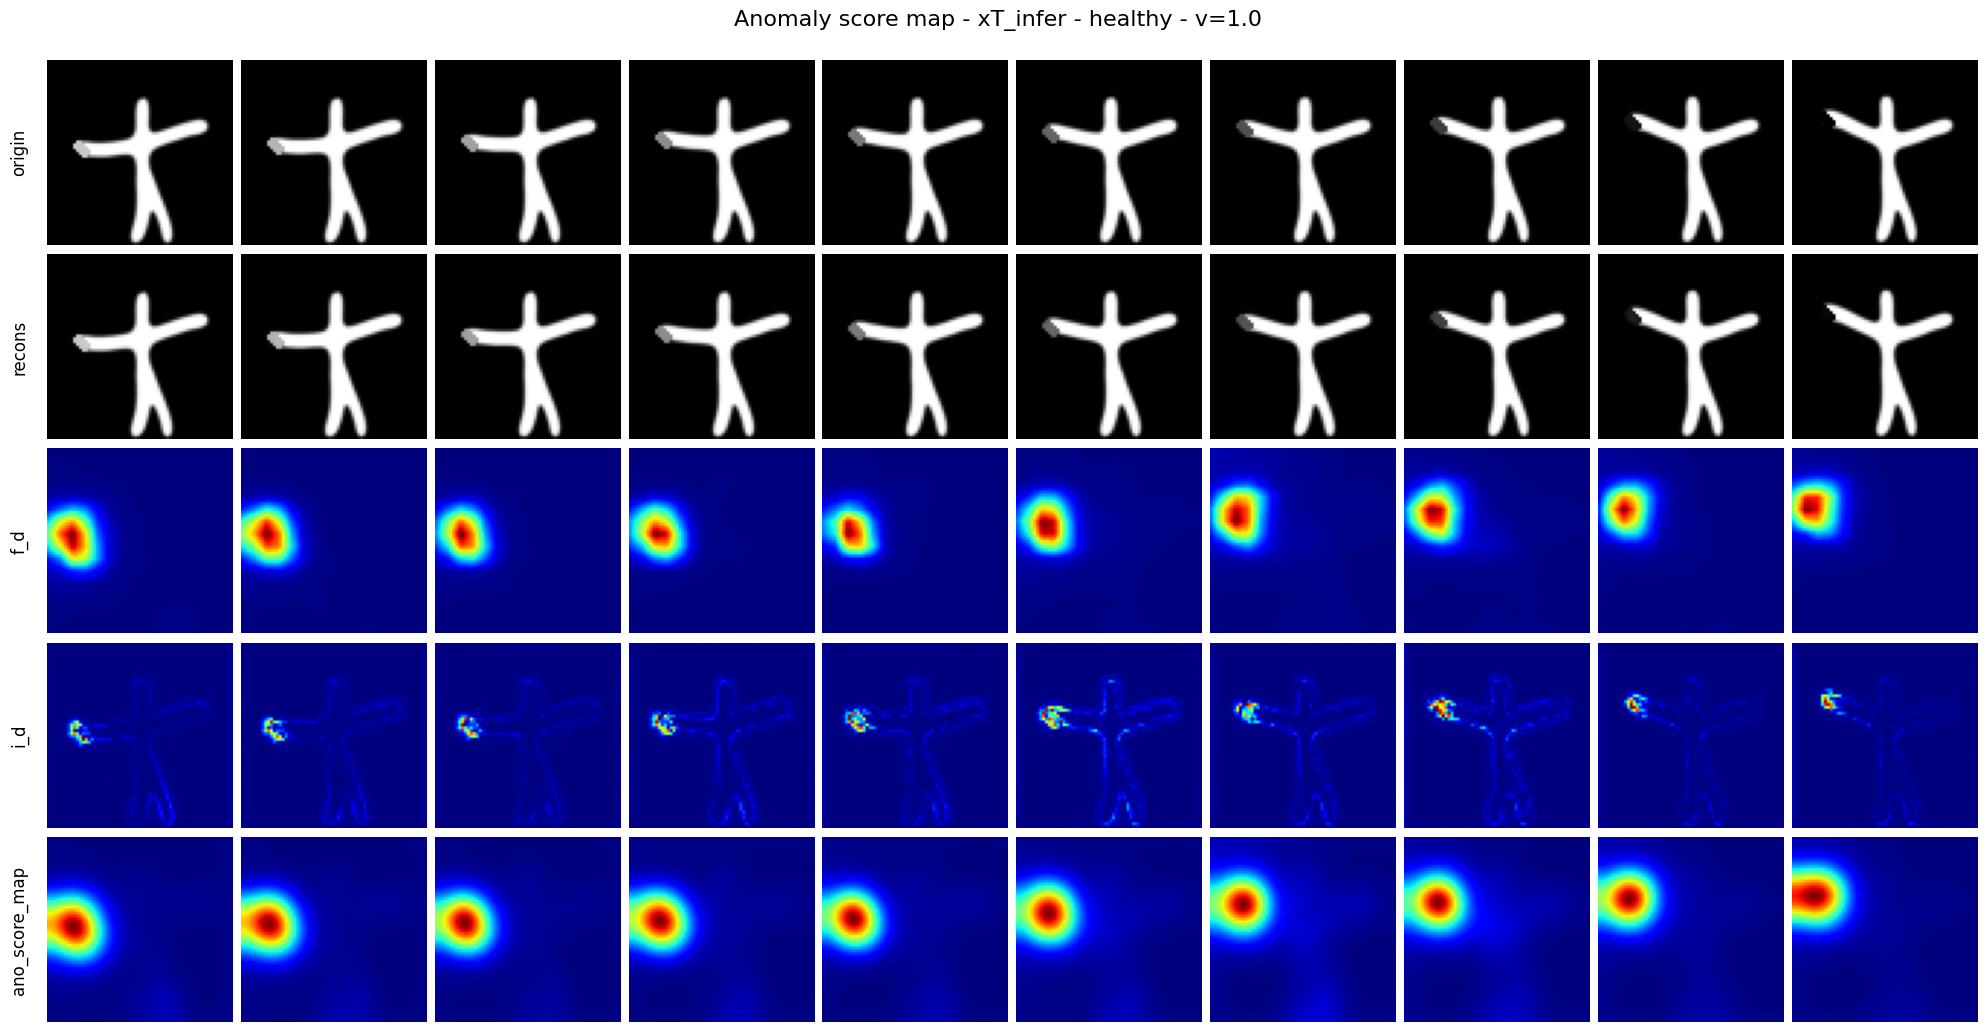

In [77]:
# Anomaly map with x_hat from xT_infer
heatmap_v = 1.
ano_map, f_d, i_d = heat_map(
    x0_hat, x0_ano, fe, v=heatmap_v, fe_layers=["layer1", "layer2"]
)

# Plot anomaly score map
imgs = [
    x0_ano.detach().cpu().squeeze(),
    x0_hat.detach().cpu().squeeze(),
    f_d.detach().cpu().squeeze(),
    i_d.detach().cpu().squeeze(),
    ano_map.detach().cpu().squeeze(),
]

labels = ["origin", "recons", "f_d", "i_d", "ano_score_map"]

title = f"Anomaly score map - xT_infer - healthy - v={heatmap_v}"
opt = {"title": title}

fig = plot_comparison_starmen(
    imgs,
    labels,
    is_errors=[False, False, True, True, True],
    opt=opt,
    same_cbar=False,
    display_cbar=True,
)

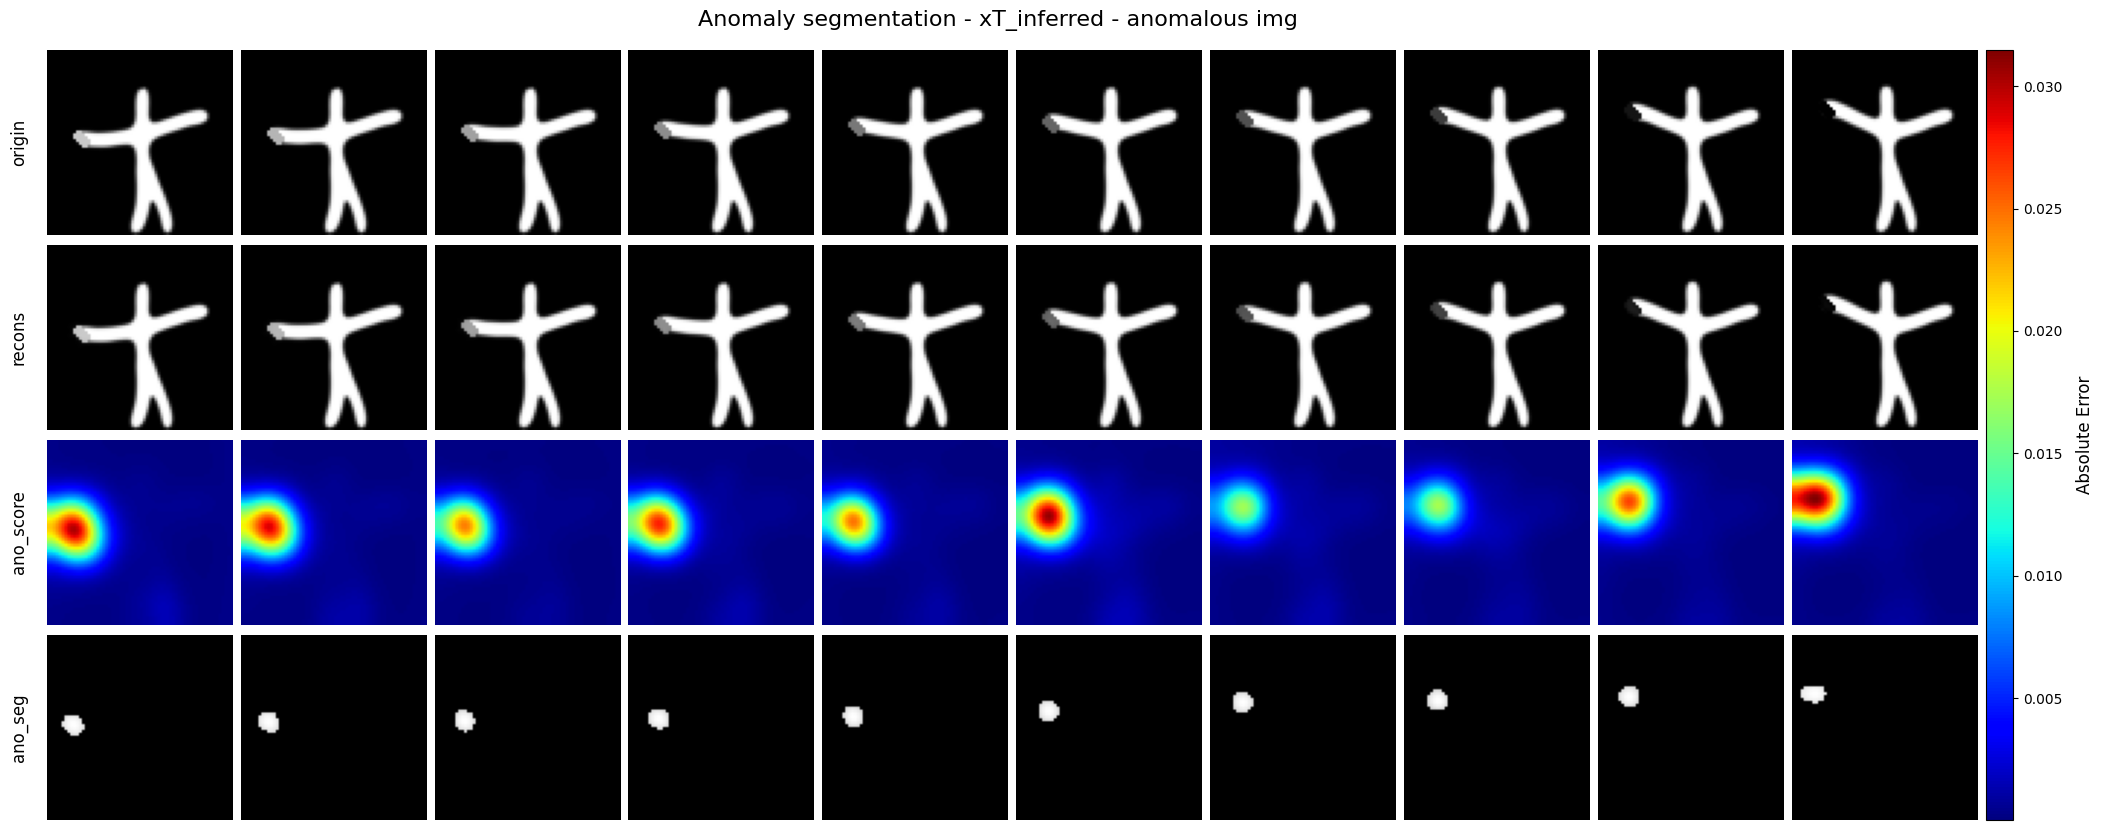

In [59]:
# Filter by simple threshold

ano_seg = filter_threshold(ano_map)
ano_seg.shape

# plt.imshow(ano_seg[8].squeeze(), cmap="gray")

# Plot anomaly segmentation thresholded
imgs = [
    x0_ano.detach().cpu().squeeze(), 
    x0_hat.detach().cpu().squeeze(),
    ano_map.detach().cpu().squeeze(),
    ano_seg.detach().cpu().squeeze(),
]

labels = [
    "origin",
    "recons",
    "ano_score",
    "ano_seg"
]

title = "Anomaly segmentation - xT_inferred - anomalous img"
opt = {
    "title": title
}

fig = plot_comparison_starmen(imgs, labels, is_errors=[False, False, True, False], opt=opt)

### 1 example


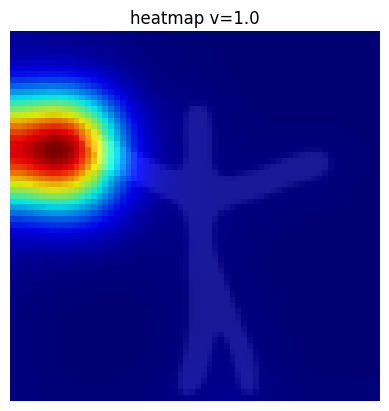

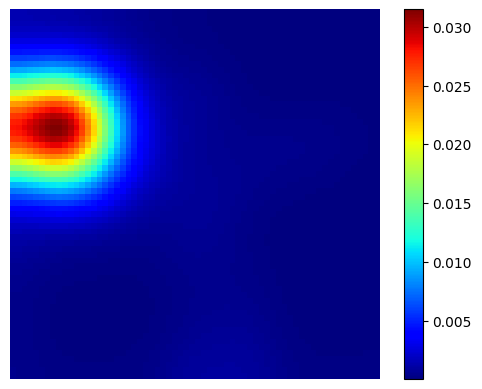

In [62]:
img = draw_featmap(ano_map[9], x0_ano[9], alpha=0.9)
plt.imshow(img)
plt.axis("off")
plt.title(f"heatmap v={heatmap_v}")
plt.show()

plt.imshow(ano_map[9].squeeze(), cmap="jet")
plt.colorbar()
plt.axis("off")
plt.show()

## Anomaly map - semantic

In [183]:
# Load 1 sample image
pidx = 9
x0_ano = out["x_orgs"][pidx]
x0_hat = out["x_recons_semantic"][pidx]
i_d = torch.abs(x0_ano - x0_hat)

### Pixel distance

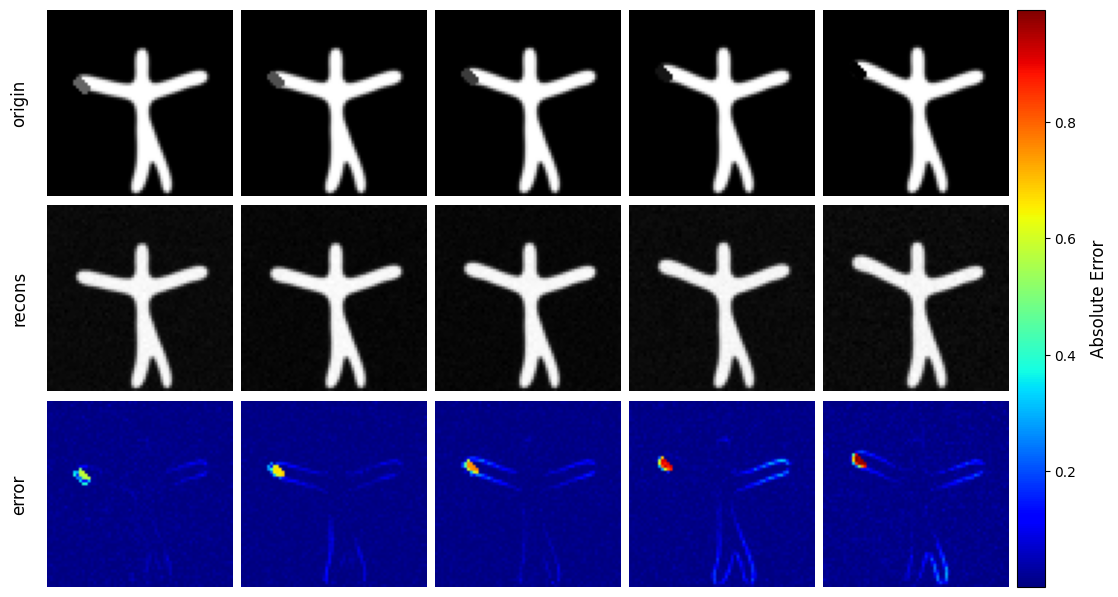

In [80]:
# Plot anomaly score map
imgs = [
    x0_ano.detach().cpu().squeeze()[5:],
    x0_hat.detach().cpu().squeeze()[5:],
    i_d.detach().cpu().squeeze()[5:],
]

labels = ["origin", "recons", "error", "ano_score_map"]

# title = f"Anomaly score map - xT_infer - {split} - v={heatmap_v}"
# opt = {"title": title}

fig = plot_comparison_starmen(
    imgs,
    labels,
    is_errors=[False, False, True, True, True],
    # opt=opt,
    same_cbar=True,
    display_cbar=True,
)

fig.savefig("notebooks/temp/pixel-error.svg")

### FAM score

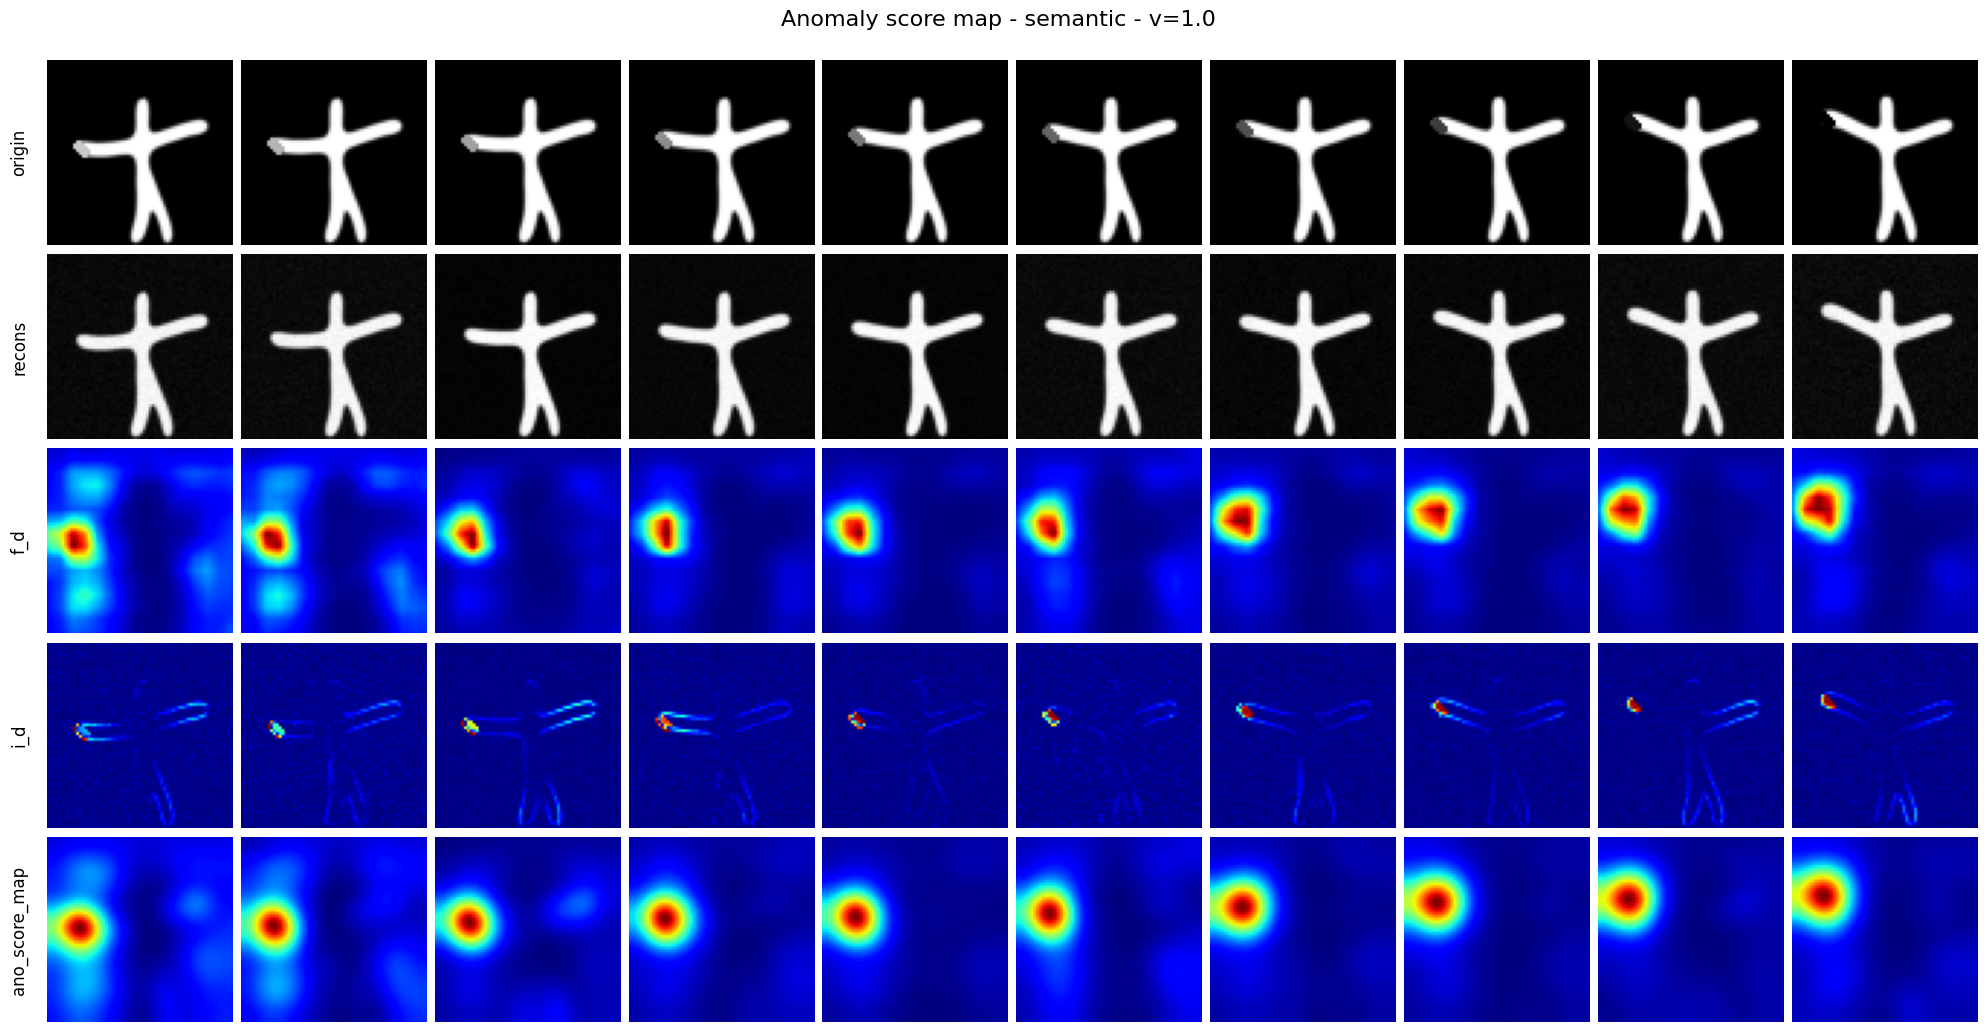

In [81]:

# Anomaly map from x0_hat_semantic
# sample from random noise
heatmap_v = 1.

ano_map, f_d, i_d = heat_map(
    x0_hat, x0_ano, fe, v=heatmap_v, fe_layers=["layer1", "layer2"]
)

# Plot anomaly score map
imgs = [
    x0_ano.detach().cpu().squeeze(),
    x0_hat.detach().cpu().squeeze(),
    f_d.detach().cpu().squeeze(),
    i_d.detach().cpu().squeeze(),
    ano_map.detach().cpu().squeeze(),
]

labels = ["origin", "recons", "f_d", "i_d", "ano_score_map"]

title = f"Anomaly score map - semantic - v={heatmap_v}"
opt = {"title": title}

fig = plot_comparison_starmen(
    imgs,
    labels,
    is_errors=[False, False, True, True, True],
    opt=opt,
    same_cbar=False,
    display_cbar=True,
)

(-0.5, 63.5, 63.5, -0.5)

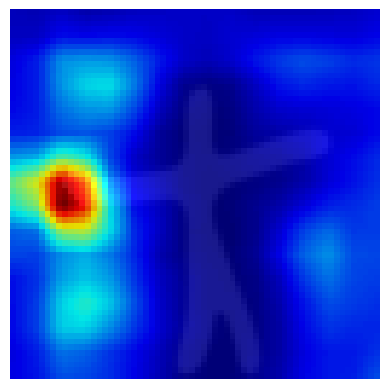

In [66]:
img = draw_featmap(f_d[0], x0_ano[0], alpha=0.9)
plt.imshow(img)
plt.axis("off")

### Histogram comparison

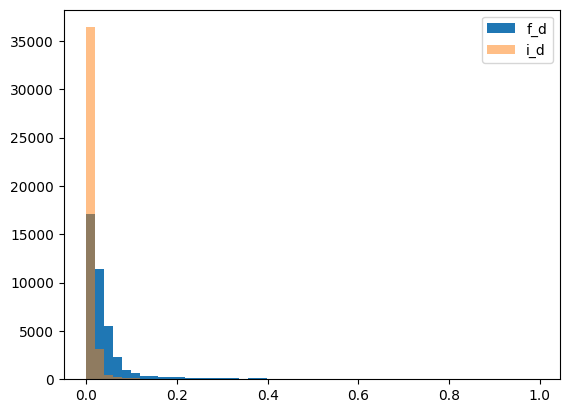

In [67]:
f_d_norm = (f_d - f_d.min()) / (f_d.max() - f_d.min() + 1e-8)

# 2. Rescale it to match the value range of i_d
i_d_min, i_d_max = i_d.min(), i_d.max()
f_d_rescaled = f_d_norm * (i_d_max - i_d_min) + i_d_min


plt.hist(f_d_rescaled.flatten(), bins=50, label="f_d")
plt.hist(i_d.flatten(), bins=50, label="i_d", alpha=0.5)
plt.legend()
plt.show()

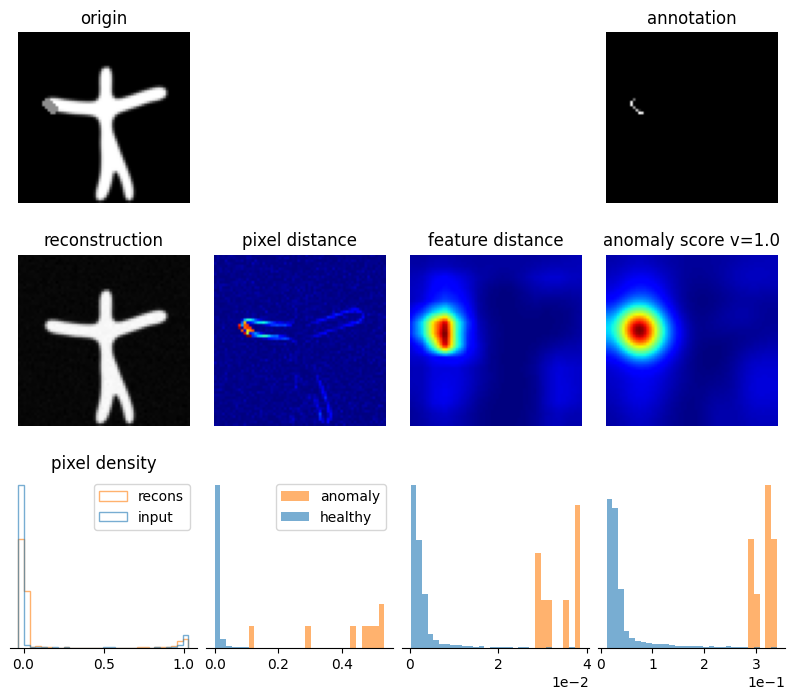

In [70]:
from src.utils.visualization import plot_fam_error_histogram

timepoint = 3
fig = plot_fam_error_histogram(
    x0_ano[timepoint],
    x0_hat[timepoint],
    x_ano_gts[pidx][timepoint],
    ano_map[timepoint],
    f_d[timepoint],
    i_d[timepoint],
    heatmap_v=1.
)

### Effect of parameter v

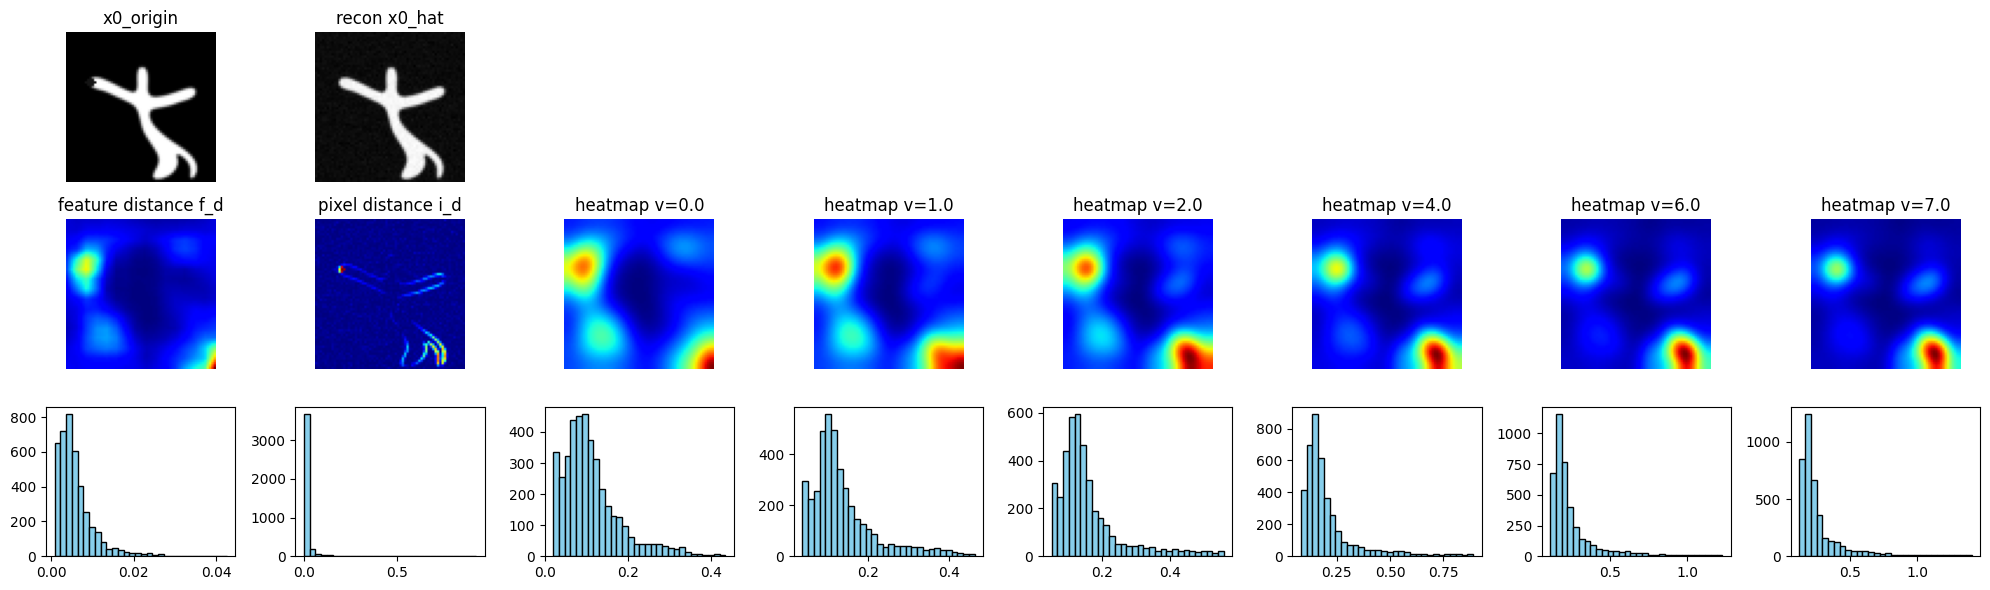

In [185]:
# Choose 1 image to plot
plotid = 9

# List of heatmap v parameters
vs = [0., 1., 2., 4., 6., 7., ]

fig, axes = plt.subplots(3, len(vs) + 2, figsize=(20, 6)) 
# for ax in np.ravel(axes):
#     ax.axis("off")

for ax in np.ravel(axes[:2, :]): 
    ax.axis("off")


# Plot x0_ano and x0_hat for all v
ax = axes[0, 0]
ax.imshow(x0_ano[plotid].squeeze(), cmap="gray")
ax.set_title("x0_origin")

ax = axes[0, 1]
ax.imshow(x0_hat[plotid].squeeze(), cmap="gray")
ax.set_title("recon x0_hat")


for i, v in enumerate(vs):
    ano_map, f_d, i_d = heat_map(
        x0_hat, x0_ano, fe, v=v, fe_layers=["layer1", "layer2"]
    )

    # Plot f_d and i_d which are the same for all v
    if i == 0: 
        ax = axes[1, 0]
        ax.imshow(f_d[plotid].squeeze(), cmap="jet")
        ax.set_title("feature distance f_d")

        ax = axes[1, 1]
        ax.imshow(i_d[plotid].squeeze(), cmap="jet")
        ax.set_title("pixel distance i_d")

        ax = axes[2, 0]
        ax.hist(f_d[plotid].flatten(), bins=30, color='skyblue', edgecolor='black')

        ax = axes[2, 1]
        ax.hist(i_d[plotid].flatten(), bins=30, color='skyblue', edgecolor='black')

    # plot anomaly heatmap
    ax = axes[1, i + 2]
    ax.imshow(ano_map[plotid].squeeze(), cmap="jet")
    ax.set_title(f"heatmap v={v}")

    # plot histogram of error
    ax = axes[2, i +2]
    ax.hist(ano_map[plotid].flatten(), bins=30, color='skyblue', edgecolor='black')

plt.tight_layout()
plt.show()


### Quantile threshold

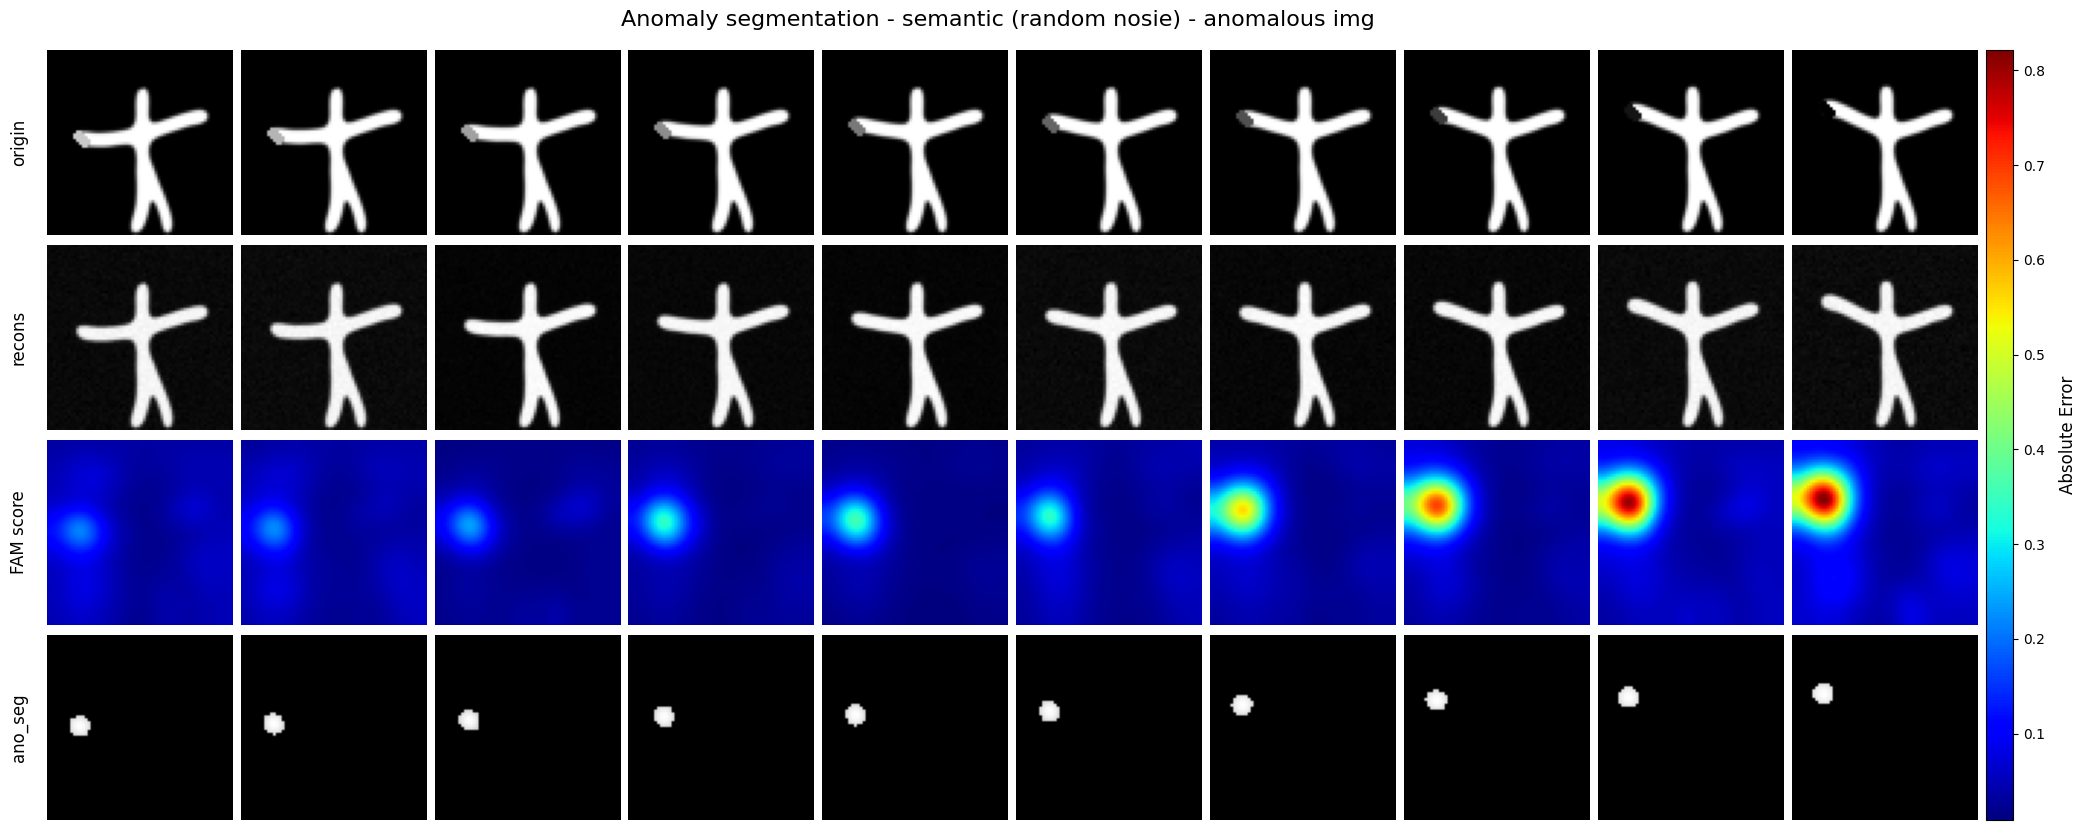

In [84]:
# Filter by simple threshold

ano_seg = filter_threshold(ano_map)
ano_seg.shape

# Plot anomaly segmentation thresholded
imgs = [
    x0_ano.detach().cpu().squeeze(), 
    x0_hat.detach().cpu().squeeze(),
    ano_map.detach().cpu().squeeze(),
    ano_seg.detach().cpu().squeeze(),
]

labels = [
    "origin",
    "recons",
    "FAM score",
    "ano_seg"
]

title = "Anomaly segmentation - semantic (random nosie) - anomalous img"
opt["title"] = title

fig = plot_comparison_starmen(imgs, labels, is_errors=[False, False, True, False], opt={"title": title})

### Yan threshold

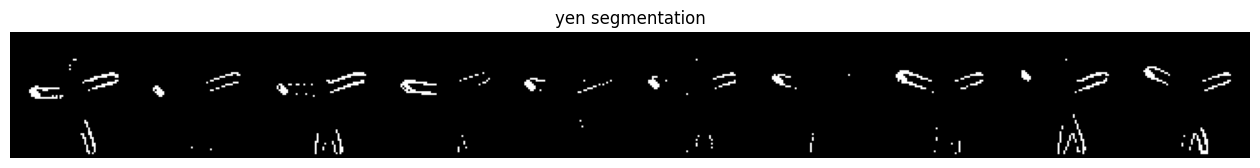

In [88]:
from skimage.filters import threshold_yen

ano_map.shape
yen_seg = torch.zeros_like(ano_map)

for i, img in enumerate(i_d):
    img = img.squeeze()
    thr = threshold_yen(img.numpy())
    segmentation = torch.where(img > thr, 1.0, 0.0)
    yen_seg[i] = segmentation.unsqueeze(0)

quick_plot_tensor(yen_seg, "yen segmentation")

### Otsu threshold

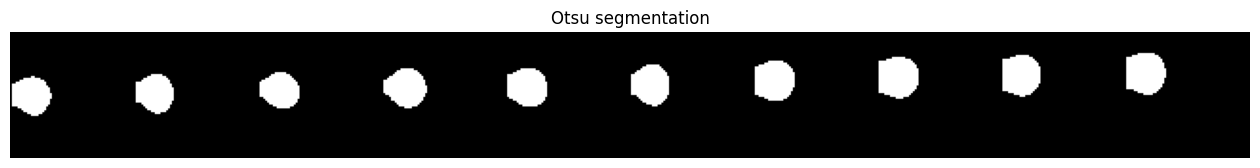

In [89]:
ano_map.shape
otsu_seg = torch.zeros_like(ano_map)

for i, img in enumerate(ano_map):
    img = img.squeeze()
    thr = threshold_otsu(img.numpy())
    segmentation = torch.where(img > thr, 1.0, 0.0)
    otsu_seg[i] = segmentation.unsqueeze(0)

quick_plot_tensor(otsu_seg, "Otsu segmentation")

# Compare heat map: Anomalous vs Healthy

Here we will compare the anomaly heatmap between a healthy image and an anomalous image (both are original images, without any reconstruction errors.)

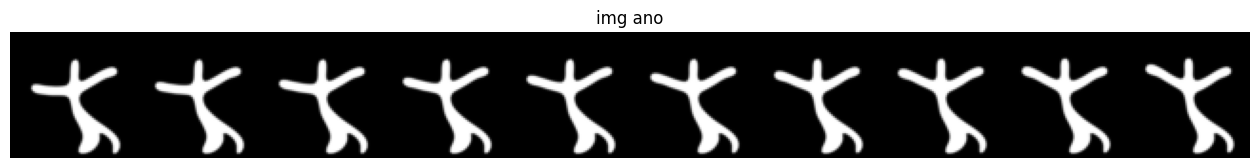

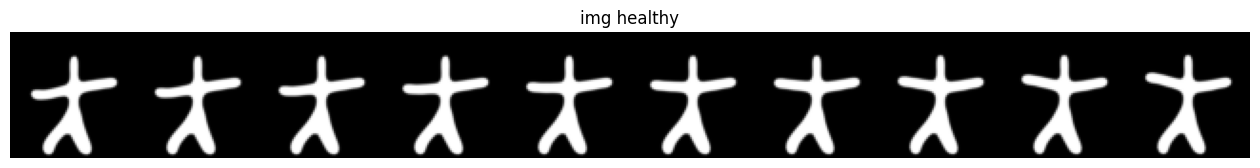

In [715]:
# Take original image of healthy and anomaly subject

img_ano = x_hts[0]
img_ht = x_hts[1]

img_ano = to_torch(img_ano)
img_ht = to_torch(img_ht)

quick_plot_tensor(img_ano, "img ano")
quick_plot_tensor(img_ht, "img healthy")

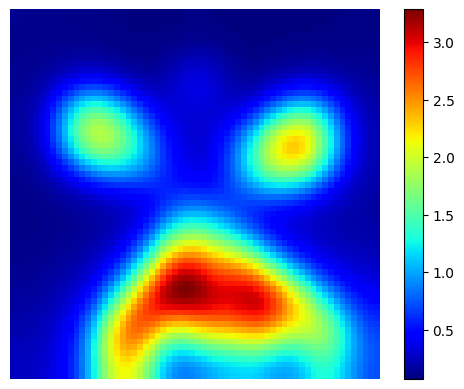

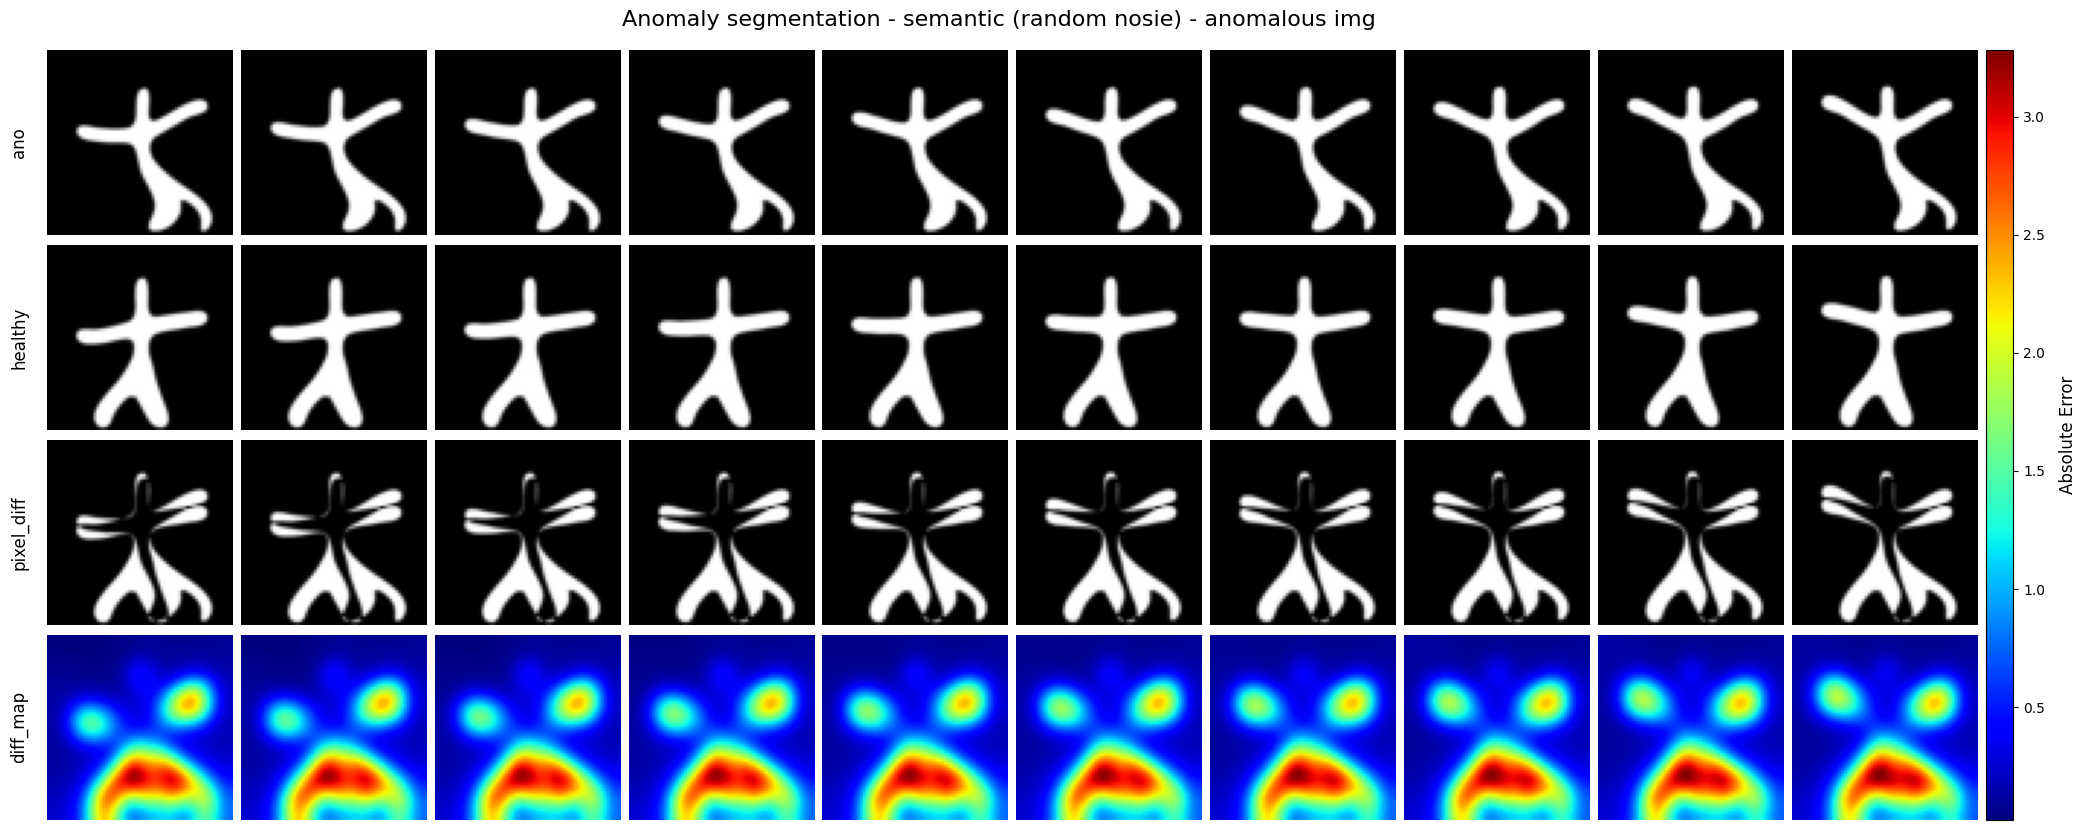

In [717]:
# Anomaly heat map between img_ht and img_ano

diff_map_ano_ht, f_d, i_d = heat_map(img_ano, img_ht, fe, v=5., fe_layers=["layer1", "layer2"])

diff_map_ano_ht.shape

plt.imshow(diff_map_ano_ht[9].squeeze(), cmap="jet")
plt.colorbar()
plt.axis("off")
plt.show()

# Plot anomaly segmentation thresholded
imgs = [
    img_ano.detach().cpu().squeeze(), 
    img_ht.detach().cpu().squeeze(),
    i_d.detach().cpu().squeeze(),
    diff_map_ano_ht.detach().cpu().squeeze(),
]

labels = [
    "ano",
    "healthy",
    "pixel_diff",
    "diff_map",
]

title = "Anomaly segmentation - semantic (random nosie) - anomalous img"
opt["title"] = title

fig = plot_comparison_starmen(imgs, labels, is_errors=[False, False, False, True], opt={"title": title})

# Export results data table

## eval_dict: darkerline

In [186]:
split = "darker_line20"
infer_dir = os.path.join(WORK_DIR, "infer", f"{split}_ddim100_noise250")

eval_result_file = os.path.join(infer_dir, "results", "eval_dict.json")
with open(eval_result_file, "r") as f:
    eval_dict = json.load(f)


# Construc pd.DataFrame for error semantic
dict_semantic = eval_dict["error_semantic"]
df_darkerline_semantic  = create_df_from_dict(dict_semantic)

# Construct data for error inferred
dict_infer = eval_dict["error_infer"]
df_darkerline_infer = create_df_from_dict(dict_infer)

df = pd.concat([df_darkerline_semantic, df_darkerline_infer], axis=1)
df

darker\_line               
                         semantic          infer
Metric Type                                     
l1     l1All        14.93 ± 42.74    0.47 ± 1.88
       l1Anomaly  400.49 ± 240.64  14.48 ± 10.88
       l1Healthy    13.06 ± 28.79    0.41 ± 1.42
       l1ratio              30.66          35.64
l2     l2All         2.05 ± 27.42    0.00 ± 0.05
       l2Anomaly  218.28 ± 216.30    0.33 ± 0.46
       l2Healthy     1.00 ± 17.33    0.00 ± 0.03
fd     fdAll          5.65 ± 9.39    0.02 ± 0.05
       fdAnomaly    42.74 ± 22.02    0.23 ± 0.07
       fdHealthy      5.47 ± 8.92    0.02 ± 0.04
sim    SSIM          84.27 ± 4.92   99.94 ± 0.04
       MSSIM         98.30 ± 0.60  100.00 ± 0.00
       PSNR          27.36 ± 2.02   54.36 ± 0.91

## eval_dict: growing_circle

In [187]:
split = "growing_circle20"
split_latex = "growing\_circle"
infer_dir = os.path.join(WORK_DIR, "infer", f"{split}_ddim100_noise250")

eval_result_file = os.path.join(infer_dir, "results", "eval_dict.json")
with open(eval_result_file, "r") as f:
    eval_dict = json.load(f)


# Construc pd.DataFrame for error semantic
dict_semantic = eval_dict["error_semantic"]
df_growingcircle_semantic  = create_df_from_dict(dict_semantic, split_latex)

# Construct data for error inferred
dict_infer = eval_dict["error_infer"]
df_growingcircle_infer = create_df_from_dict(dict_infer, split_latex)

df = pd.concat([df_growingcircle_semantic, df_growingcircle_infer], axis=1)
df

growing\_circle              
                         semantic         infer
Metric Type                                    
l1     l1All       32.79 ± 125.79   0.75 ± 2.07
       l1Anomaly  743.48 ± 372.27   6.52 ± 6.44
       l1Healthy    16.44 ± 33.34   0.62 ± 1.63
       l1ratio              45.23         10.58
l2     l2All       16.90 ± 118.55   0.00 ± 0.08
       l2Anomaly  691.34 ± 388.77   0.08 ± 0.45
       l2Healthy     1.38 ± 13.98   0.00 ± 0.04
fd     fdAll        31.50 ± 81.52   0.02 ± 0.05
       fdAnomaly  306.74 ± 165.98   0.10 ± 0.08
       fdHealthy    25.17 ± 66.19   0.02 ± 0.05
sim    SSIM         75.00 ± 14.64  99.86 ± 0.05
       MSSIM         93.76 ± 5.09  99.99 ± 0.00
       PSNR          21.19 ± 6.57  53.19 ± 0.66

## eval_dict: darker_circle

In [208]:
split = "darker_circle20"
split_latex = "darker\_circle"
infer_dir = os.path.join(WORK_DIR, "infer", f"{split}_ddim100_noise250")

eval_result_file = os.path.join(infer_dir, "results", "eval_dict.json")
with open(eval_result_file, "r") as f:
    eval_dict = json.load(f)


# Construc pd.DataFrame for error semantic
dict_semantic = eval_dict["error_semantic"]
df_darkercircle_semantic  = create_df_from_dict(dict_semantic, split_latex)

# Construct data for error inferred
dict_infer = eval_dict["error_infer"]
df_darkercircle_infer = create_df_from_dict(dict_infer, split_latex)

df = pd.concat([df_darkercircle_semantic, df_darkercircle_infer], axis=1)
df

darker\_circle               
                         semantic          infer
Metric Type                                     
l1     l1All        14.60 ± 37.13    0.59 ± 2.09
       l1Anomaly  385.45 ± 230.77  19.93 ± 14.25
       l1Healthy    13.50 ± 28.58    0.53 ± 1.64
       l1ratio              28.56          37.65
l2     l2All         1.59 ± 19.48    0.00 ± 0.08
       l2Anomaly  201.81 ± 198.32    0.60 ± 0.93
       l2Healthy     1.00 ± 12.06    0.00 ± 0.05
fd     fdAll          3.94 ± 4.49    0.03 ± 0.07
       fdAnomaly     25.94 ± 7.16    0.36 ± 0.11
       fdHealthy      3.87 ± 4.32    0.03 ± 0.07
sim    SSIM          84.53 ± 4.91   99.92 ± 0.04
       MSSIM         98.52 ± 0.48  100.00 ± 0.00
       PSNR          28.43 ± 1.87   53.52 ± 1.40

## eval_dict: test healthy

In [209]:
split = "test"
split_latex = "test\_healthy"
infer_dir = os.path.join(WORK_DIR, "infer", f"{split}_ddim100_noise250")

eval_result_file = os.path.join(infer_dir, "results", "eval_dict.json")
with open(eval_result_file, "r") as f:
    eval_dict = json.load(f)

print(eval_result_file)

workdir/diffae_starmen/infer/test_ddim100_noise250/results/eval_dict.json


In [211]:
# Construc pd.DataFrame for error semantic
dict_semantic = eval_dict["error_semantic"]
df_test_semantic  = create_df_from_dict(dict_semantic, split_latex)

# Construct data for error inferred
dict_infer = eval_dict["error_infer"]
df_test_infer = create_df_from_dict(dict_infer, split_latex)

df = pd.concat([df_test_semantic, df_test_infer], axis=1)
df

test\_healthy               
                       semantic          infer
Metric Type                                   
l1     l1All      12.61 ± 23.94    1.04 ± 1.97
       l1Anomaly            NaN            NaN
       l1Healthy            NaN            NaN
       l1ratio              NaN            NaN
l2     l2All        0.73 ± 8.26    0.00 ± 0.03
       l2Anomaly            NaN            NaN
       l2Healthy            NaN            NaN
fd     fdAll        2.48 ± 2.02    0.01 ± 0.01
       fdAnomaly            NaN            NaN
       fdHealthy            NaN            NaN
sim    SSIM        85.70 ± 5.12   99.89 ± 0.02
       MSSIM       98.85 ± 0.50  100.00 ± 0.00
       PSNR        32.66 ± 3.00   53.27 ± 1.32

## Combination of result

In [219]:

# Export to Latex table
# keys = ["l1All", "l1Anomaly", "l1Healthy", "l1ratio"]

# list_df = [df_test_semantic, df_test_infer,
        #    df_growingcircle_semantic, df_growingcircle_infer,]

list_df = [df_darkerline_semantic, df_darkerline_infer,
           df_darkercircle_semantic, df_darkercircle_infer,]

df_tex = pd.concat(list_df, axis=1)


# change name

level0_rename = {
    'l1': r'$l1\mathrm{-error}$',  
    'l2': r'$l2\mathrm{-error}$',
    'fd': r'feature-error'
}

level1_rename = {
    'l1All': r'$l1 \mathrm{-All}$ (e-3) $\downarrow$',
    'l1Anomaly': r'$l1 \mathrm{-Anomaly}$ (e-3) $\uparrow$',
    'l1Healthy': r'$l1 \mathrm{-Healthy}$ (e-3) $\downarrow$',
    'l1ratio': r'$l1 \mathrm{-ratio} \uparrow$',

    'l2All': r'$l2 \mathrm{-All}$ (e-3) $\downarrow$',
    'l2Anomaly': r'$l2 \mathrm{-Anomaly}$ (e-3) $\uparrow$',
    'l2Healthy': r'$l2 \mathrm{-Healthy}$ (e-3) $\downarrow$',

    'fdAll': r'$D_{f} \mathrm{-All}$ (e-3) $\downarrow$',
    'fdAnomaly': r'$D_{f} \mathrm{-Anomaly}$ (e-3) $\uparrow$',
    'fdHealthy': r'$D_{f} \mathrm{-Healthy}$ (e-3) $\downarrow$',

    'SSIM': r'SSIM $\uparrow$',
    'MSSIM': r'MSSIM $\uparrow$',
    'PSNR': r'PSNR $\uparrow$',
}


df_tex = df_tex.rename(index=lambda x: level0_rename.get(x, x), level=0)
df_tex = df_tex.rename(index=lambda x: level1_rename.get(x, x), level=1)

# Remove index level name
df_tex.index.names = [None, None] 
df_tex = df_tex.reset_index(level=0, drop=True)


tex_table = df_tex.to_latex(
    index=True, 
    escape=False,
    column_format="l" + len(list_df) * "r",
    na_rep="-"
)
print(tex_table)

\begin{tabular}{lrrrr}
\toprule
 & \multicolumn{2}{r}{darker\_line} & \multicolumn{2}{r}{darker\_circle} \\
 & semantic & infer & semantic & infer \\
\midrule
$l1 \mathrm{-All}$ (e-3) $\downarrow$ & 14.93 ± 42.74 & 0.47 ± 1.88 & 14.60 ± 37.13 & 0.59 ± 2.09 \\
$l1 \mathrm{-Anomaly}$ (e-3) $\uparrow$ & 400.49 ± 240.64 & 14.48 ± 10.88 & 385.45 ± 230.77 & 19.93 ± 14.25 \\
$l1 \mathrm{-Healthy}$ (e-3) $\downarrow$ & 13.06 ± 28.79 & 0.41 ± 1.42 & 13.50 ± 28.58 & 0.53 ± 1.64 \\
$l1 \mathrm{-ratio} \uparrow$ & 30.66 & 35.64 & 28.56 & 37.65 \\
$l2 \mathrm{-All}$ (e-3) $\downarrow$ & 2.05 ± 27.42 & 0.00 ± 0.05 & 1.59 ± 19.48 & 0.00 ± 0.08 \\
$l2 \mathrm{-Anomaly}$ (e-3) $\uparrow$ & 218.28 ± 216.30 & 0.33 ± 0.46 & 201.81 ± 198.32 & 0.60 ± 0.93 \\
$l2 \mathrm{-Healthy}$ (e-3) $\downarrow$ & 1.00 ± 17.33 & 0.00 ± 0.03 & 1.00 ± 12.06 & 0.00 ± 0.05 \\
$D_{f} \mathrm{-All}$ (e-3) $\downarrow$ & 5.65 ± 9.39 & 0.02 ± 0.05 & 3.94 ± 4.49 & 0.03 ± 0.07 \\
$D_{f} \mathrm{-Anomaly}$ (e-3) $\uparrow$ & 42.74

In [44]:
df_tex

darker\_line                 \
                                                     semantic          infer   
$l1 \mathrm{-All}$ (e-3) $\downarrow$           14.93 ± 42.74    0.47 ± 1.88   
$l1 \mathrm{-Anomaly}$ (e-3) $\uparrow$       400.49 ± 240.64  14.48 ± 10.88   
$l1 \mathrm{-Healthy}$ (e-3) $\downarrow$       13.06 ± 28.79    0.41 ± 1.42   
$l1 \mathrm{-ratio} \uparrow$                         30.6648        35.6386   
$l2 \mathrm{-All}$ (e-3) $\downarrow$            2.05 ± 27.42    0.00 ± 0.05   
$l2 \mathrm{-Anomaly}$ (e-3) $\uparrow$       218.28 ± 216.30    0.33 ± 0.46   
$l2 \mathrm{-Healthy}$ (e-3) $\downarrow$        1.00 ± 17.33    0.00 ± 0.03   
$D_{f} \mathrm{-All}$ (e-3) $\downarrow$          5.65 ± 9.39    0.02 ± 0.05   
$D_{f} \mathrm{-Anomaly}$ (e-3) $\uparrow$      42.74 ± 22.02    0.23 ± 0.07   
$D_{f} \mathrm{-Healthy}$ (e-3) $\downarrow$      5.47 ± 8.92    0.02 ± 0.04   

                                              growing\_circle               \
                                                     semantic        infer   
$l1 \mathrm{-All}$ (e-3) $\downarrow$          32.79 ± 125.79  0.75 ± 2.07   
$l1 \mathrm{-Anomaly}$ (e-3) $\uparrow$       743.48 ± 372.27  6.52 ± 6.44   
$l1 \mathrm{-Healthy}$ (e-3) $\downarrow$       16.44 ± 33.34  0.62 ± 1.63   
$l1 \mathrm{-ratio} \uparrow$                         45.2257      10.5840   
$l2 \mathrm{-All}$ (e-3) $\downarrow$          16.90 ± 118.55  0.00 ± 0.08   
$l2 \mathrm{-Anomaly}$ (e-3) $\uparrow$       691.34 ± 388.77  0.08 ± 0.45   
$l2 \mathrm{-Healthy}$ (e-3) $\downarrow$        1.38 ± 13.98  0.00 ± 0.04   
$D_{f} \mathrm{-All}$ (e-3) $\downarrow$        31.50 ± 81.52  0.02 ± 0.05   
$D_{f} \mathrm{-Anomaly}$ (e-3) $\uparrow$    306.74 ± 165.98  0.10 ± 0.08   
$D_{f} \mathrm{-Healthy}$ (e-3) $\downarrow$    25.17 ± 66.19  0.02 ± 0.05   

                                               darker\_circle                 
                                                     semantic          infer  
$l1 \mathrm{-All}$ (e-3) $\downarrow$           14.60 ± 37.13    0.59 ± 2.09  
$l1 \mathrm{-Anomaly}$ (e-3) $\uparrow$       385.45 ± 230.77  19.93 ± 14.25  
$l1 \mathrm{-Healthy}$ (e-3) $\downarrow$       13.50 ± 28.58    0.53 ± 1.64  
$l1 \mathrm{-ratio} \uparrow$                         28.5568        37.6540  
$l2 \mathrm{-All}$ (e-3) $\downarrow$            1.59 ± 19.48    0.00 ± 0.08  
$l2 \mathrm{-Anomaly}$ (e-3) $\uparrow$       201.81 ± 198.32    0.60 ± 0.93  
$l2 \mathrm{-Healthy}$ (e-3) $\downarrow$        1.00 ± 12.06    0.00 ± 0.05  
$D_{f} \mathrm{-All}$ (e-3) $\downarrow$          3.94 ± 4.49    0.03 ± 0.07  
$D_{f} \mathrm{-Anomaly}$ (e-3) $\uparrow$       25.94 ± 7.16    0.36 ± 0.11  
$D_{f} \mathrm{-Healthy}$ (e-3) $\downarrow$      3.87 ± 4.32    0.03 ± 0.07

# Anomaly Score

## Helper function


In [206]:


def ano_score_max(x):
    x = x.view(x.size(0), -1) 
    return torch.amax(x, dim=1)

def ano_score_mean(x):
    x = x.view(x.size(0), -1) 
    return torch.mean(x, dim=1)

def ano_score_mean_tops(x, s=100):
    x = x.view(x.size(0), -1) 
    top_x, top_idx = torch.topk(x, k=s, dim=1)
    return torch.nanmean(top_x, dim=1)

def ano_score_mean_quantile(x, q=0.95):
    x = x.view(x.size(0), -1) 
    q_val = torch.quantile(x, q, dim=1, keepdim=True)
    mask = x >= q_val  #(B, N)
    top_x = torch.where(mask, x, torch.tensor(float('nan'), device=x.device))
    return torch.nanmean(top_x, dim=1)

## Combine all test dataset

In [ ]:
# Load anomaly test dataset

import json


def load_test_dataset(split="growing_circle20"):

    import json 

    infer_dir = os.path.join(WORK_DIR, "infer", f"{split}_ddim100_noise250")

    # Test dataset
    test_ds = StarmenDataset(
    data_dir=DATA_DIR,
    split=split,
    nb_subject=None,
    )
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=1)
    print(f"Len of test dataset: {len(test_loader)}")


    # Read the reconstruction error files to get the index and corresponding reonconstruction image
    try: 
        eval_result_file = os.path.join(infer_dir, "results", "eval_dict.json")
        with open(eval_result_file, "r") as f:
            eval_dict = json.load(f)
        test_ids = eval_dict["IDs"]
        print(f"Load from eval dict: {eval_result_file}")
    # test_ids = np.load(recons_idx_path)
    # test_ids = test_ids.squeeze().tolist()
    except FileNotFoundError:
        test_ids = test_ds.ids

    # Load the original (anomalious) image from test dataset by index
    x_orgs = [test_ds.get_images_by_id(id)["img"].squeeze() for id in test_ids]
    x_orgs = np.stack(x_orgs).astype("float32")

    # Load the groundtruth anomaly mask 
    x_ano_gts = []
    for id in test_ds.ids:
        x_ano_gt = test_ds.get_images_by_id(id)["anomaly_gt_seg"]

        if x_ano_gt is None:
            break
        else:
            x_ano_gts.append(x_ano_gt.squeeze())

    if len(x_ano_gts) > 0: 
        x_ano_gts = np.stack(x_ano_gts).astype("float32")
        x_ano_gts.shape

    # Load the original healthy images
    # healthy path example= data/starmen/output_random_noacc/images/SimulatedData__Reconstruction__starman__subject_s0__tp_0.npy
    x_hts = []
    for id in test_ids:
        for t in range(0, 10):
            ht_path = os.path.join(DATA_DIR, "images", f"SimulatedData__Reconstruction__starman__subject_s{id}__tp_{t}.npy")
            ht = np.load(ht_path)
            x_hts.append(ht)
    x_hts = np.stack(x_hts)
    x_hts = rearrange(x_hts, "(b t) h w -> b t h w", t=10)
    x_hts.shape

    # add C dimension
    x_orgs = rearrange(x_orgs, "b t h w -> b t 1 h w")
    if len(x_ano_gts) > 0:
        x_ano_gts = rearrange(x_ano_gts, "b t h w -> b t 1 h w")
    x_hts = rearrange(x_hts, "b t h w -> b t 1 h w")

    # Load reconstruction - xT_inferred
    x_recons = np.load(os.path.join(infer_dir, "results", "recons.npy"))
    x_recons.shape

    # Load reconstruction - from random noise
    x_recons_semantic = np.load(os.path.join(infer_dir, "results", "recons_semantic.npy"))
    x_recons_semantic.shape

    # convert to torch
    x_orgs = to_torch(x_orgs) if not isinstance(x_orgs, torch.Tensor) else x_orgs
    x_hts = to_torch(x_hts) if not isinstance(x_hts, torch.Tensor) else x_hts
    x_ano_gts = to_torch(x_ano_gts) if not isinstance(x_ano_gts, torch.Tensor) else x_ano_gts
    x_recons = to_torch(x_recons) if not isinstance(x_recons, torch.Tensor) else x_recons
    x_recons_semantic = to_torch(x_recons_semantic) if not isinstance(x_recons_semantic, torch.Tensor) else x_recons_semantic

    return {
        "x_orgs": x_orgs,
        "x_hts": x_hts,
        "x_ano_gts": x_ano_gts,
        "x_recons": x_recons,
        "x_recons_semantic": x_recons_semantic,
    }

In [8]:
# growing_circle20 dataset
out_growing_circle = load_test_dataset(split="growing_circle20")

# darker_line20 dataset
out_darker_line = load_test_dataset(split="darker_line20")

# darker_circle20 dataset
out_darker_circle = load_test_dataset(split="darker_circle20")

# test dataset
out_test = load_test_dataset(split="test")

Len of test dataset: 20
Len of test dataset: 20
Len of test dataset: 20
Len of test dataset: 150


In [11]:
out_growing_circle["x_orgs"].shape

test = out_growing_circle["x_orgs"]
test = test[0]
test.shape

torch.Size([10, 1, 64, 64])

In [ ]:
# combine all dataset into 1
outs = [out_growing_circle, out_darker_line, out_darker_circle, out_test]
for i, out in enumerate(outs):
    b, t, c, h, w = out["x_orgs"].shape
    if i == 0: 
        x_orgs = out["x_orgs"]
        x_recons = out["x_recons"]
        x_recons_semantic = out["x_recons_semantic"]
        x_ano_gts = out["x_ano_gts"]
        true_label = torch.full((b, t), 1)
    else: 
        x_orgs = torch.concat((x_orgs, out["x_orgs"]))
        x_recons = torch.concat((x_recons, out["x_recons"]))
        x_recons_semantic = torch.concat((x_recons_semantic, out["x_recons_semantic"]))
        if i != 3: 
            x_ano_gts = torch.concat((x_ano_gts, out["x_ano_gts"]))
        y = torch.full((b, t), 1) if i != 3 else torch.full((b, t), 0)
        true_label = torch.concat((true_label, y))



## Calculate anomaly score image level

In [34]:
from src.utils.metrics import compute_roc, compute_prc


# x_ins = torch.cat((x_orgs[:5], x_orgs[-5:]), dim=0)
# x_outs = torch.cat((x_recons[:5], x_recons[-5:]), dim=0)

vs = [4., 5., 6., 7., 8.]

def calculate_img_anomaly_score(eval_dict, x_ins, x_outs, x_ano_gts=None, v=7., tops=100, q=0.95):
    """
    Calculate image level anomaly score based on pixel-level anomaly score
    Args: 
        eval_dict
        x_ins: original images. (B, T, C, H, W)
        x_outs: reconstructed images. (B, T, C, H, W)
        x_ano_gts: ground truth anomay segmentation. 
        v: hyperparameters controls the strength of pixel-wise difference 
        tops: hyperparameters to calculate the mean of top pixel-wise diff as image anomaly score. 
        q: hyperparameters to calculate mean of q quantile of pixel-wise diff as image anomaly score.

    Returns: 
        eval_dict. 


    """
    img_ano_score_max = []
    img_ano_score_mean = []
    img_ano_score_mean_tops = []
    img_ano_score_quantile = []

    B, T = x_ins.shape[0], x_ins.shape[1]
    v = 7.
    tops = 100  # top s pixels to calculate imgScore
    q = 0.95  # quantile to calculate imgScore

    for i in range(B):
        x0 = x_ins[i]
        xhat = x_outs[i]
        if x_ano_gts is not None: 
            ano_gt = x_ano_gts[i]

        # Pixel wise anomaly score
        ano_map, f_d, i_d = heat_map(
            xhat, x0, fe, v=v, fe_layers=["layer1", "layer2", "layer3"]
        )

        # Image wise anomaly score
        img_ano_score_max.append(ano_score_max(ano_map).tolist())
        img_ano_score_mean.append(ano_score_mean(ano_map).tolist())
        img_ano_score_mean_tops.append(ano_score_mean_tops(ano_map, s=tops).tolist())
        img_ano_score_quantile.append(ano_score_mean_quantile(ano_map, q=q).tolist())

        # # Pixel-wise segmentation error
        # if true_label[i][0] == 1: 
        #     P_AUROC, _fpr, _tpr, _threshs = compute_roc(ano_map.squeeze().flatten().numpy(), 
        #                                                 ano_gt.squeeze().flatten().numpy().astype(bool))
        #     P_AUPRC, _precisions, _recalls, _threshs = compute_prc(ano_map.squeeze().flatten().numpy(),
        #                                                            ano_gt.squeeze().flatten().numpy().astype(bool))

    # Write ImgAnomalyScore to dict
    img_ano_scores_dict = {
        "v": v,
        "tops": tops,
        "quantile": q
    }

    img_ano_scores_dict["img_ano_score_max"] = img_ano_score_max
    img_ano_scores_dict["img_ano_score_mean"] = img_ano_score_mean
    img_ano_scores_dict["img_ano_score_mean_tops"] = img_ano_score_mean_tops
    img_ano_scores_dict["img_ano_score_quantile"] = img_ano_score_quantile

    # Image-wise AUROC, AUPRC
    pred_y = np.array(img_ano_score_max).flatten()
    pred_y.shape

    y = [[i] * T for i in eval_dict["labelPerVol"]]
    y = np.array(y).flatten()
    y.shape

    AUROC, _fpr, _tpr, _threshs = compute_roc(pred_y, y)
    AUPRC, _precisions, _recalls, _threshs = compute_prc(pred_y, y)

    img_ano_scores_dict["AUROC"] = AUROC
    img_ano_scores_dict["AUPRC"] = AUPRC

    eval_dict["error_semantic"]["ImageAnomalyScores"] = img_ano_scores_dict

    return eval_dict


## ImgScore - growing_circle

In [36]:
split = "growing_circle20"
split_latex = "growing\_circle"
infer_dir = os.path.join(WORK_DIR, "infer", f"{split}_ddim100_noise250")

eval_result_file = os.path.join(infer_dir, "results", "eval_dict.json")
with open(eval_result_file, "r") as f:
    eval_dict = json.load(f)

eval_dict["labelPerVol"]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
x_ins = out_growing_circle["x_orgs"]
x_outs = out_growing_circle["x_recons_semantic"]
x_ano_gts = out_growing_circle["x_ano_gts"]


eval_dict = calculate_img_anomaly_score(eval_dict, x_ins, x_outs, x_ano_gts=None)

/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


In [39]:
## Save eval_dict
import json
with open(eval_result_file, "w") as f:
    json.dump(eval_dict, f)

## ImgScore - darker_circle


In [41]:
split = "darker_circle20"
infer_dir = os.path.join(WORK_DIR, "infer", f"{split}_ddim100_noise250")

eval_result_file = os.path.join(infer_dir, "results", "eval_dict.json")
with open(eval_result_file, "r") as f:
    eval_dict = json.load(f)

eval_dict["error_semantic"]

{'type': 'semantic',
 'l1errAllMean': 0.01459552999585867,
 'l1errAllStd': 0.037127599120140076,
 'l1errAnomalyMean': 0.38544943928718567,
 'l1errAnomalyStd': 0.23077397048473358,
 'l1errHealthyMean': 0.013497656211256981,
 'l1errHealthyStd': 0.02857597917318344,
 'l1ratio': 28.5567684173584,
 'l2errAllMean': 0.0015914866235107183,
 'l2errAllStd': 0.01948431506752968,
 'l2errAnomalyMean': 0.20180585980415344,
 'l2errAnomalyStd': 0.19832295179367065,
 'l2errHealthyMean': 0.0009987723315134645,
 'l2errHealthyStd': 0.012056147679686546,
 'fdAllMean': 0.003938455134630203,
 'fdAllStd': 0.004491119179874659,
 'fdAnomalyMean': 0.025938089936971664,
 'fdAnomalyStd': 0.0071566421538591385,
 'fdHealthyMean': 0.003873327746987343,
 'fdHealthyStd': 0.0043175541795790195,
 'SSIMMetricsMean': 0.8453065752983093,
 'SSIMMetricsStd': 0.04914521798491478,
 'MSSIMMetricsMean': 0.9851980805397034,
 'MSSIMMetricsStd': 0.004824587609618902,
 'PSNRMetricsMean': 28.4250545501709,
 'PSNRMetricsStd': 1.8703049

In [42]:
x_ins = out_darker_circle["x_orgs"]
x_outs = out_darker_circle["x_recons_semantic"]
x_ano_gts = out_darker_circle["x_ano_gts"]

eval_dict = calculate_img_anomaly_score(eval_dict, x_ins, x_outs, x_ano_gts=None)

/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


In [43]:
## Save eval_dict
import json
with open(eval_result_file, "w") as f:
    json.dump(eval_dict, f)

## ImgScore - darker_line20

In [44]:
split = "darker_line20"
infer_dir = os.path.join(WORK_DIR, "infer", f"{split}_ddim100_noise250")

eval_result_file = os.path.join(infer_dir, "results", "eval_dict.json")
with open(eval_result_file, "r") as f:
    eval_dict = json.load(f)

eval_dict["error_semantic"]

{'type': 'semantic',
 'l1errAllMean': 0.014932969585061073,
 'l1errAllStd': 0.04274166375398636,
 'l1errAnomalyMean': 0.4004870355129242,
 'l1errAnomalyStd': 0.24064147472381592,
 'l1errHealthyMean': 0.013060154393315315,
 'l1errHealthyStd': 0.02879108302295208,
 'l1ratio': 30.6648006439209,
 'l2errAllMean': 0.002049840986728668,
 'l2errAllStd': 0.027421625331044197,
 'l2errAnomalyMean': 0.21828359365463257,
 'l2errAnomalyStd': 0.2163008451461792,
 'l2errHealthyMean': 0.000999493058770895,
 'l2errHealthyStd': 0.017325395718216896,
 'fdAllMean': 0.005649341270327568,
 'fdAllStd': 0.009389134123921394,
 'fdAnomalyMean': 0.042738255113363266,
 'fdAnomalyStd': 0.022021105512976646,
 'fdHealthyMean': 0.005469182971864939,
 'fdHealthyStd': 0.008917106315493584,
 'SSIMMetricsMean': 0.8426631689071655,
 'SSIMMetricsStd': 0.049203626811504364,
 'MSSIMMetricsMean': 0.982997715473175,
 'MSSIMMetricsStd': 0.0059877620078623295,
 'PSNRMetricsMean': 27.35995101928711,
 'PSNRMetricsStd': 2.0168836116

In [45]:
x_ins = out_darker_line["x_orgs"]
x_outs = out_darker_line["x_recons_semantic"]
x_ano_gts = out_darker_line["x_ano_gts"]

eval_dict = calculate_img_anomaly_score(eval_dict, x_ins, x_outs, x_ano_gts=None)

## Save eval_dict
with open(eval_result_file, "w") as f:
    json.dump(eval_dict, f)

/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


## ImgScore - test

In [ ]:
split = "test"
infer_dir = os.path.join(WORK_DIR, "infer", f"{split}_ddim100_noise250")

eval_result_file = os.path.join(infer_dir, "results", "eval_dict.json")
with open(eval_result_file, "r") as f:
    eval_dict = json.load(f)

eval_dict["error_semantic"]

{'type': 'semantic',
 'l1errAllMean': 0.012612924911081791,
 'l1errAllStd': 0.023935196921229362,
 'l1errAnomalyMean': nan,
 'l1errAnomalyStd': nan,
 'l1errHealthyMean': nan,
 'l1errHealthyStd': nan,
 'l1ratio': nan,
 'l2errAllMean': 0.0007319794385693967,
 'l2errAllStd': 0.00826406292617321,
 'l2errAnomalyMean': nan,
 'l2errAnomalyStd': nan,
 'l2errHealthyMean': nan,
 'l2errHealthyStd': nan,
 'fdAllMean': 0.002475180895999074,
 'fdAllStd': 0.0020202328450977802,
 'fdAnomalyMean': nan,
 'fdAnomalyStd': nan,
 'fdHealthyMean': nan,
 'fdHealthyStd': nan,
 'SSIMMetrics': [[0.9153473973274231,
   0.9174937605857849,
   0.8709973096847534,
   0.8356812000274658,
   0.8876163959503174,
   0.8524996042251587,
   0.9326069951057434,
   0.9001457691192627,
   0.858670711517334,
   0.899847149848938],
  [0.8194816708564758,
   0.7980750799179077,
   0.9211443662643433,
   0.8859841227531433,
   0.8330992460250854,
   0.7440341114997864,
   0.8761307597160339,
   0.7516086101531982,
   0.831482708

In [47]:
x_ins = out_test["x_orgs"]
x_outs = out_test["x_recons_semantic"]

eval_dict = calculate_img_anomaly_score(eval_dict, x_ins, x_outs, x_ano_gts=None)

## Save eval_dict
with open(eval_result_file, "w") as f:
    json.dump(eval_dict, f)

/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


## ImgScore - val

In [209]:
# val dataset
out_val = load_test_dataset(split="val")

split = "val"
infer_dir = os.path.join(WORK_DIR, "infer", f"{split}_ddim100_noise250")

eval_result_file = os.path.join(infer_dir, "results", "eval_dict.json")
with open(eval_result_file, "r") as f:
    eval_dict = json.load(f)

eval_dict["error_semantic"]

Len of test dataset: 150


{'type': 'semantic',
 'l1errAllMean': 0.012322156690061092,
 'l1errAllStd': 0.022015012800693512,
 'l1errAnomalyMean': nan,
 'l1errAnomalyStd': nan,
 'l1errHealthyMean': nan,
 'l1errHealthyStd': nan,
 'l1ratio': nan,
 'l2errAllMean': 0.0006364961736835539,
 'l2errAllStd': 0.006607824470847845,
 'l2errAnomalyMean': nan,
 'l2errAnomalyStd': nan,
 'l2errHealthyMean': nan,
 'l2errHealthyStd': nan,
 'fdAllMean': 0.0024247122928500175,
 'fdAllStd': 0.0018940572626888752,
 'fdAnomalyMean': nan,
 'fdAnomalyStd': nan,
 'fdHealthyMean': nan,
 'fdHealthyStd': nan,
 'SSIMMetricsMean': 0.8581244945526123,
 'SSIMMetricsStd': 0.050494104623794556,
 'MSSIMMetricsMean': 0.9887447953224182,
 'MSSIMMetricsStd': 0.004742505494505167,
 'PSNRMetricsMean': 33.02753829956055,
 'PSNRMetricsStd': 2.7656850814819336}

In [210]:
x_ins = out_test["x_orgs"]
x_outs = out_test["x_recons_semantic"]

eval_dict = calculate_img_anomaly_score(eval_dict, x_ins, x_outs, x_ano_gts=None)

## Save eval_dict
with open(eval_result_file, "w") as f:
    json.dump(eval_dict, f)

/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


## Combine dataset to calculate AUPRC

In [61]:
splits = ["test", "darker_line20", "darker_circle20", "growing_circle20"]

pred_y_max = []
pred_y_mean = []
pred_y_mean_tops = []
pred_y_quantile = []
y = []

for split in splits: 
    infer_dir = os.path.join(WORK_DIR, "infer", f"{split}_ddim100_noise250")

    eval_result_file = os.path.join(infer_dir, "results", "eval_dict.json")
    with open(eval_result_file, "r") as f:
        eval_dict = json.load(f)

    labels = [[i] * 10 for i in eval_dict["labelPerVol"]]
    labels = np.array(labels).flatten()
    y.append(labels)

    # Anomaly score using Max value
    img_score_max = eval_dict["error_semantic"]["ImageAnomalyScores"]["img_ano_score_max"]
    img_score_max = np.array(img_score_max).flatten()
    pred_y_max.append(img_score_max)

    # Anomaly score using Mean value
    img_ano_score_mean = eval_dict["error_semantic"]["ImageAnomalyScores"]["img_ano_score_mean"]
    img_ano_score_mean = np.array(img_ano_score_mean).flatten()
    pred_y_mean.append(img_ano_score_mean)

    # Anomaly score using Mean tops
    img_ano_score_mean_tops = eval_dict["error_semantic"]["ImageAnomalyScores"]["img_ano_score_mean_tops"]
    img_ano_score_mean_tops = np.array(img_ano_score_mean_tops).flatten()
    pred_y_mean_tops.append(img_ano_score_mean_tops)

    # Anomaly score using 95th percentile
    img_ano_score_quantile = eval_dict["error_semantic"]["ImageAnomalyScores"]["img_ano_score_max"]
    img_ano_score_quantile = np.array(img_ano_score_quantile).flatten()
    pred_y_quantile.append(img_ano_score_quantile)

In [221]:
all_y = np.concat(y, axis=0)
all_pred_y_max = np.concat(pred_y_max, axis=0)
all_pred_y_mean = np.concat(pred_y_mean, axis=0)
all_pred_y_mean_tops = np.concat(pred_y_mean_tops, axis=0)
all_pred_y_quantile = np.concat(pred_y_quantile, axis=0)

# Calculate AUPRC, AUROC metrics
AUROC_max, _fpr_max, _tpr_max, _threshs = compute_roc(all_pred_y_max, all_y)
AUPRC_max, _precisions_max, _recalls_max, _threshs = compute_prc(all_pred_y_max, all_y)

AUROC_mean, _fpr_mean, _tpr_mean, _threshs = compute_roc(all_pred_y_mean, all_y)
AUPRC_mean, _precisions_mean, _recalls_mean, _threshs = compute_prc(all_pred_y_mean, all_y)

AUROC_mean_tops, _fpr_tops, _tpr_tops, _threshs = compute_roc(all_pred_y_mean_tops, all_y)
AUPRC_mean_tops, _precisions_tops, _recalls_tops, _threshs = compute_prc(all_pred_y_mean_tops, all_y)

AUROC_quantile, _fpr_quantile, _tpr_quantile, _threshs = compute_roc(all_pred_y_quantile, all_y)
AUPRC_quantile, _precisions_quantile, _recalls_quantile, _threshs = compute_prc(all_pred_y_quantile, all_y)

imgAUScoreMetrics = {
    "AUROC_max": AUROC_max.item(),
    "AUPRC_max": AUPRC_max.item(), 
    "AUROC_mean": AUROC_mean.item(),
    "AUPRC_mean": AUPRC_mean.item(), 
    "AUROC_mean_tops": AUROC_mean_tops.item(),
    "AUPRC_mean_tops": AUPRC_mean_tops.item(), 
    "AUROC_quantile": AUROC_quantile.item(),
    "AUPRC_quantile": AUPRC_quantile.item(), 
}

imgAUScoreMetrics

{'AUROC_max': 0.9838911111111112,
 'AUPRC_max': 0.9468576384888561,
 'AUROC_mean': 0.9657255555555555,
 'AUPRC_mean': 0.9197801287361619,
 'AUROC_mean_tops': 0.9828177777777777,
 'AUPRC_mean_tops': 0.9444756891654391,
 'AUROC_quantile': 0.9838911111111112,
 'AUPRC_quantile': 0.9468576384888561}

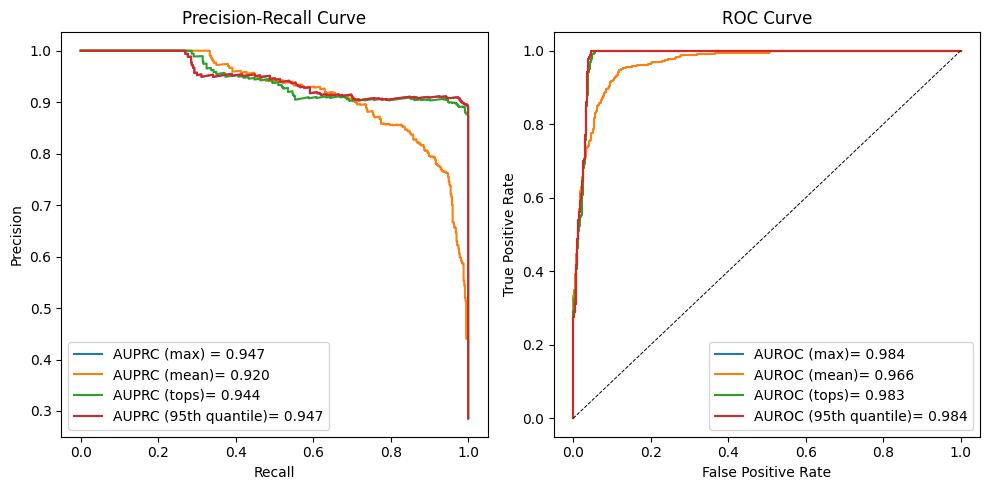

In [225]:
plt.figure(figsize=(10, 5))

# AUPRC plot
plt.subplot(1, 2, 1)
plt.plot(_recalls_max, _precisions_max, label=f'AUPRC (max) = {AUPRC_max:.3f}')
plt.plot(_recalls_mean, _precisions_mean, label=f'AUPRC (mean)= {AUPRC_mean:.3f}')
plt.plot(_recalls_tops, _precisions_tops, label=f'AUPRC (tops)= {AUPRC_mean_tops:.3f}')
plt.plot(_recalls_quantile, _precisions_quantile, label=f'AUPRC (95th quantile)= {AUPRC_quantile:.3f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

# AUROC plot
plt.subplot(1, 2, 2)
plt.plot(_fpr_max, _tpr_max, label=f'AUROC (max)= {AUROC_max:.3f}')
plt.plot(_fpr_mean, _tpr_mean, label=f'AUROC (mean)= {AUROC_mean:.3f}')
plt.plot(_fpr_tops, _tpr_tops, label=f'AUROC (tops)= {AUROC_mean_tops:.3f}')
plt.plot(_fpr_quantile, _tpr_quantile, label=f'AUROC (95th quantile)= {AUROC_quantile:.3f}')

plt.plot([0, 1], [0, 1], 'k--', lw=0.7)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.tight_layout()
plt.show()

## Thresholding by val dataset

We will choose p-percentile of val (healthy) dataset as our threhold to evaluate anomaly detection from imgAnomalyScore. 

In [211]:
split = "val"

infer_dir = os.path.join(WORK_DIR, "infer", f"{split}_ddim100_noise250")

eval_result_file = os.path.join(infer_dir, "results", "eval_dict.json")
with open(eval_result_file, "r") as f:
    eval_dict = json.load(f)


# We use the max value of pixel-wise anomaly score. 
pred_y_test = eval_dict["error_semantic"]["ImageAnomalyScores"]["img_ano_score_max"]
pred_y_test = np.array(pred_y_test).flatten()
pred_y_test.shape

p_95 = np.percentile(pred_y_test, q=95)
p_90 = np.percentile(pred_y_test, q=90)
p_99 = np.percentile(pred_y_test, q=99)



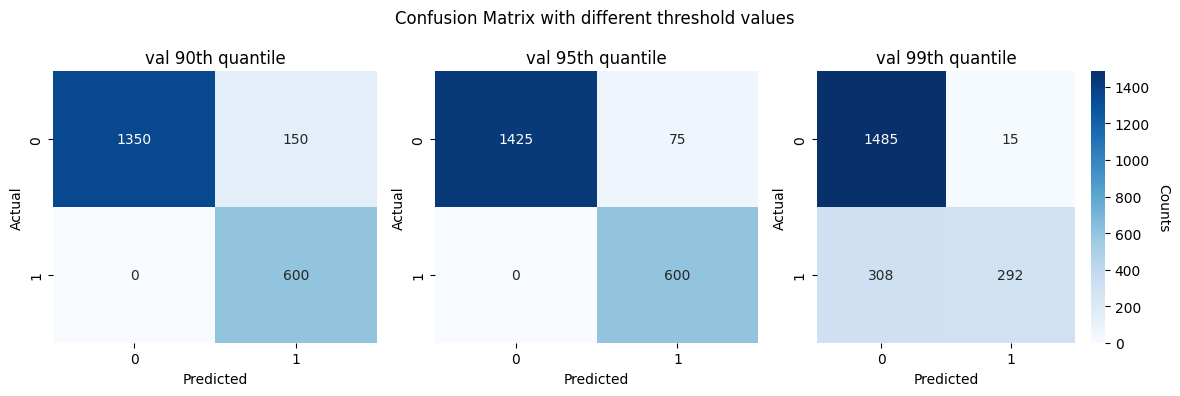

In [244]:
# Threshold anomaly score

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

thres_names = ["val 90th quantile", "val 95th quantile", "val 99th quantile"]
thresholds = [p_90, p_95, p_99]

conf_matrices = []
for threshold in thresholds:
    all_pred_thresholded = all_pred_y_max > threshold
    cm = confusion_matrix(all_y, all_pred_thresholded)
    conf_matrices.append(cm)

# Find global min/max for color scale
vmin = min(cm.min() for cm in conf_matrices)
vmax = max(cm.max() for cm in conf_matrices)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot with shared colorbar
heatmaps = []
for i, cm in enumerate(conf_matrices):
    ax = axes[i]
    sns_hm = sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        ax=ax,
        cbar=(i == len(conf_matrices) - 1),      # Only show cbar on last plot
        vmin=vmin,
        vmax=vmax
    )
    heatmaps.append(sns_hm)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{thres_names[i]}')

# Add a single shared colorbar to the right of the last heatmap
# Use the last heatmap's colorbar for consistency
cbar = heatmaps[-1].collections[0].colorbar
cbar.ax.set_ylabel('Counts', rotation=270, labelpad=15)

plt.suptitle("Confusion Matrix with different threshold values")
plt.tight_layout()
plt.show()

In [245]:
# Threshold anomaly score
threshold = p_95

# growing_circle20
split = "growing_circle20"
infer_dir = os.path.join(WORK_DIR, "infer", f"{split}_ddim100_noise250")

eval_result_file = os.path.join(infer_dir, "results", "eval_dict.json")
with open(eval_result_file, "r") as f:
    eval_dict = json.load(f)

pred_y_growing_circle = eval_dict["error_semantic"]["ImageAnomalyScores"]["img_ano_score_max"]
pred_y_growing_circle = np.array(pred_y_growing_circle).flatten()
ano_growing_circle = pred_y_growing_circle > threshold

# darker_circle20
split = "darker_circle20"
infer_dir = os.path.join(WORK_DIR, "infer", f"{split}_ddim100_noise250")

eval_result_file = os.path.join(infer_dir, "results", "eval_dict.json")
with open(eval_result_file, "r") as f:
    eval_dict = json.load(f)

pred_y_darker_circle = eval_dict["error_semantic"]["ImageAnomalyScores"]["img_ano_score_max"]
pred_y_darker_circle = np.array(pred_y_darker_circle).flatten()
ano_darker_circle = pred_y_darker_circle > threshold

# darker_line20
split = "darker_line20"
infer_dir = os.path.join(WORK_DIR, "infer", f"{split}_ddim100_noise250")

eval_result_file = os.path.join(infer_dir, "results", "eval_dict.json")
with open(eval_result_file, "r") as f:
    eval_dict = json.load(f)

pred_y_darker_line = eval_dict["error_semantic"]["ImageAnomalyScores"]["img_ano_score_max"]
pred_y_darker_line = np.array(pred_y_darker_line).flatten()
ano_darker_line = pred_y_darker_line > threshold

In [145]:
threshold

np.float64(0.02700463272631168)

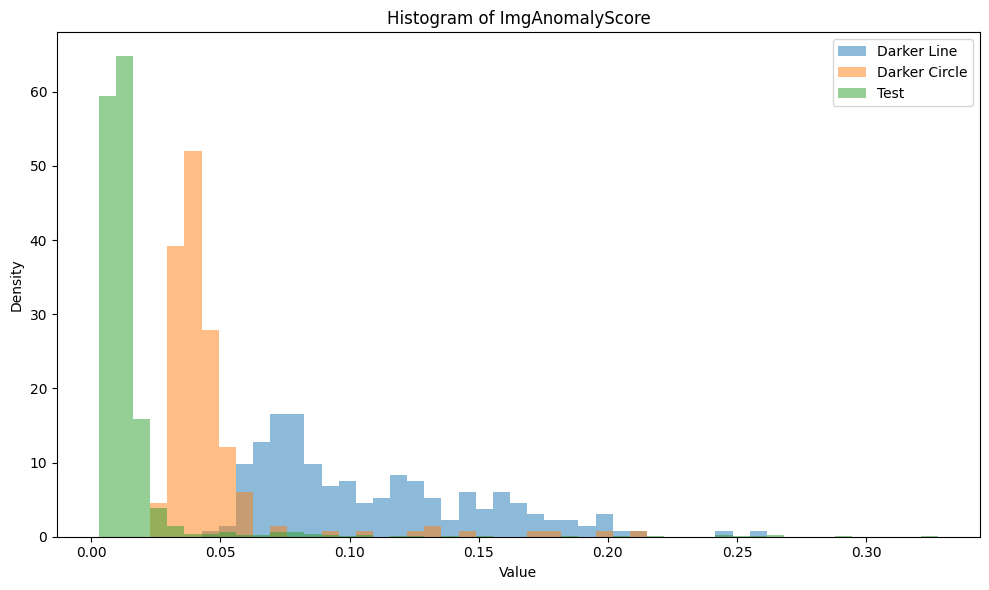

In [149]:
# Plot histogram of ImgAnomalyScore

arrays = [
    (pred_y_darker_line, "Darker Line"),
    # (pred_y_growing_circle, "Growing Circle"),
    (pred_y_darker_circle, "Darker Circle"),
    (pred_y_test, "Test")
]

all_data = np.concatenate([arr for arr, _ in arrays])
min_val, max_val = np.min(all_data), np.max(all_data)

# Define common bin edges
bins = np.linspace(min_val, max_val, 50)

# Plot histograms with shared bins
plt.figure(figsize=(10, 6))
for data, label in arrays:
    plt.hist(data, bins=bins, alpha=0.5, label=label, histtype="bar", density=True)

plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Histogram of ImgAnomalyScore")
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()

In [165]:
pred_y_growing_circle.argmax()
pred_y_growing_circle.shape

# darker_circle20
split = "growing_circle20"
infer_dir = os.path.join(WORK_DIR, "infer", f"{split}_ddim100_noise250")

eval_result_file = os.path.join(infer_dir, "results", "eval_dict.json")
with open(eval_result_file, "r") as f:
    eval_dict = json.load(f)

test = eval_dict["error_semantic"]["ImageAnomalyScores"]["img_ano_score_max"]

result = None
for i, imgs in enumerate(test):
    for j, img in enumerate(imgs): 
        if img == pred_y_growing_circle.max():
            result = (i, j)

print(result)

(14, 9)


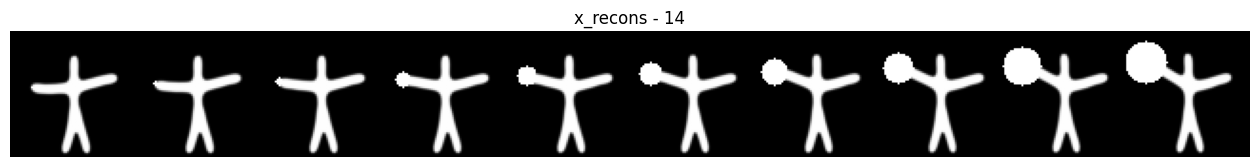

In [170]:
x_org = out_growing_circle["x_orgs"][14]
x_recon = out_growing_circle["x_recons_semantic"][14]

quick_plot_tensor(x_org, "x_recons - 14")

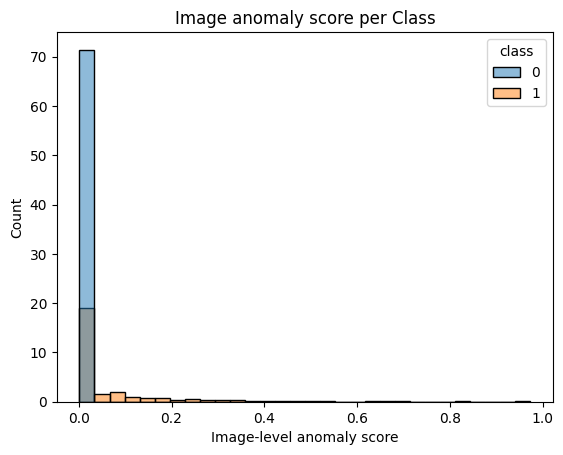

In [83]:
# Plot histogram of ImgAnomalyScore

import seaborn as sns

df = pd.DataFrame({
    'pred_y': all_pred_y_mean,
    'class': all_y
})
sns.histplot(data=df, x='pred_y', hue='class', bins=30, element='bars', stat='percent', common_bins=True, alpha=0.5)

plt.title("Image anomaly score per Class")
plt.xlabel("Image-level anomaly score")
plt.ylabel("Count")
# plt.legend(title='Class', labels=["healthy", "anomaly"])
plt.show()
